In [1]:
import time
import argparse
import scipy.sparse as sp
import numpy as np
import torch
import ipdb
from scipy.io import loadmat
import networkx as nx
import multiprocessing as mp
import torch.nn.functional as F
from functools import partial
import random
from sklearn.metrics import roc_auc_score, f1_score
from copy import deepcopy
from scipy.spatial.distance import pdist,squareform
import torch.nn as nn
import math
from torch.nn.parameter import Parameter
import matplotlib.pyplot as plt 
from torch.nn.modules.module import Module
from torch.nn import init
import torch.optim as optim
import networkx as nx
import tensorflow as tf
import pandas as pd

In [2]:
def split_arti(labels, c_train_num):
    #labels: n-dim Longtensor, each element in [0,...,m-1].
    #cora: m=7
    num_classes = len(set(labels.tolist()))
    c_idxs = [] # class-wise index
    train_idx = []
    val_idx = []
    test_idx = []
    c_num_mat = np.zeros((num_classes,3)).astype(int)
    c_num_mat[:,1] = 25
    c_num_mat[:,2] = 55

    for i in range(num_classes):
        c_idx = (labels==i).nonzero()[:,-1].tolist()
        print('{:d}-th class sample number: {:d}'.format(i,len(c_idx)))
        random.shuffle(c_idx)
        c_idxs.append(c_idx)

        train_idx = train_idx + c_idx[:c_train_num[i]]
        c_num_mat[i,0] = c_train_num[i]

        val_idx = val_idx + c_idx[c_train_num[i]:(c_train_num[i]+int(c_train_num[i]*.2))]
        test_idx = test_idx + c_idx[int(c_train_num[i]+(c_train_num[i]*.2)):]

    random.shuffle(train_idx)

    #ipdb.set_trace()

    train_idx = torch.LongTensor(train_idx)
    val_idx = torch.LongTensor(val_idx)
    test_idx = torch.LongTensor(test_idx)
    #c_num_mat = torch.LongTensor(c_num_mat)


    return train_idx, val_idx, test_idx, c_num_mat


In [3]:
def src_upsample(adj,features,labels,idx_train, portion=1.0, im_class_num=3):
    c_largest = labels.max().item()
    adj_back = adj
    chosen = None

    #ipdb.set_trace()
    avg_number = int(idx_train.shape[0]/(c_largest+1))

    for i in range(im_class_num):
        new_chosen = idx_train[(labels==(c_largest-i))[idx_train]]
        if portion == 0:#refers to even distribution
            c_portion = int(avg_number/new_chosen.shape[0])

            for j in range(c_portion):
                if chosen is None:
                    chosen = new_chosen
                else:
                    chosen = torch.cat((chosen, new_chosen), 0)

        else:
            c_portion = int(portion)
            portion_rest = portion-c_portion
            for j in range(c_portion):
                num = int(new_chosen.shape[0])
                new_chosen = new_chosen[:num]

                if chosen is None:
                    chosen = new_chosen
                else:
                    chosen = torch.cat((chosen, new_chosen), 0)
            
            num = int(new_chosen.shape[0]*portion_rest)
            new_chosen = new_chosen[:num]

            if chosen is None:
                chosen = new_chosen
            else:
                chosen = torch.cat((chosen, new_chosen), 0)
            

    add_num = chosen.shape[0]
    new_adj = adj_back.new(torch.Size((adj_back.shape[0]+add_num, adj_back.shape[0]+add_num)))
    new_adj[:adj_back.shape[0], :adj_back.shape[0]] = adj_back[:,:]
    new_adj[adj_back.shape[0]:, :adj_back.shape[0]] = adj_back[chosen,:]
    new_adj[:adj_back.shape[0], adj_back.shape[0]:] = adj_back[:,chosen]
    new_adj[adj_back.shape[0]:, adj_back.shape[0]:] = adj_back[chosen,:][:,chosen]

    #ipdb.set_trace()
    features_append = deepcopy(features[chosen,:])
    labels_append = deepcopy(labels[chosen])
    idx_new = np.arange(adj_back.shape[0], adj_back.shape[0]+add_num)
    idx_train_append = idx_train.new(idx_new)

    features = torch.cat((features,features_append), 0)
    labels = torch.cat((labels,labels_append), 0)
    idx_train = torch.cat((idx_train,idx_train_append), 0)
    adj = new_adj

    return adj, features, labels, idx_train

In [4]:
def src_smote(adj,features,labels,idx_train, portion=1.0, im_class_num=3):
    c_largest = labels.max().item()
    adj_back = adj
    chosen = None
    new_features = None

    #ipdb.set_trace()
    avg_number = int(idx_train.shape[0]/(c_largest+1))

    for i in range(im_class_num):
        new_chosen = idx_train[(labels==(c_largest-i))[idx_train]]
        if portion == 0:#refers to even distribution
            c_portion = int(avg_number/new_chosen.shape[0])

            portion_rest = (avg_number/new_chosen.shape[0]) - c_portion

        else:
            c_portion = int(portion)
            portion_rest = portion-c_portion
            
        for j in range(c_portion):
            num = int(new_chosen.shape[0])
            new_chosen = new_chosen[:num]

            chosen_embed = features[new_chosen,:]
            distance = squareform(pdist(chosen_embed.detach()))
            np.fill_diagonal(distance,distance.max()+100)

            idx_neighbor = distance.argmin(axis=-1)
            
            interp_place = random.random()
            embed = chosen_embed + (chosen_embed[idx_neighbor,:]-chosen_embed)*interp_place

            if chosen is None:
                chosen = new_chosen
                new_features = embed
            else:
                chosen = torch.cat((chosen, new_chosen), 0)
                new_features = torch.cat((new_features, embed),0)
            
        num = int(new_chosen.shape[0]*portion_rest)
        new_chosen = new_chosen[:num]

        chosen_embed = features[new_chosen,:]
        distance = squareform(pdist(chosen_embed.detach()))
        np.fill_diagonal(distance,distance.max()+100)

        idx_neighbor = distance.argmin(axis=-1)
            
        interp_place = random.random()
        embed = chosen_embed + (chosen_embed[idx_neighbor,:]-chosen_embed)*interp_place

        if chosen is None:
            chosen = new_chosen
            new_features = embed
        else:
            chosen = torch.cat((chosen, new_chosen), 0)
            new_features = torch.cat((new_features, embed),0)
            

    add_num = chosen.shape[0]
    new_adj = adj_back.new(torch.Size((adj_back.shape[0]+add_num, adj_back.shape[0]+add_num)))
    new_adj[:adj_back.shape[0], :adj_back.shape[0]] = adj_back[:,:]
    new_adj[adj_back.shape[0]:, :adj_back.shape[0]] = adj_back[chosen,:]
    new_adj[:adj_back.shape[0], adj_back.shape[0]:] = adj_back[:,chosen]
    new_adj[adj_back.shape[0]:, adj_back.shape[0]:] = adj_back[chosen,:][:,chosen]

    #ipdb.set_trace()
    features_append = deepcopy(new_features)
    labels_append = deepcopy(labels[chosen])
    idx_new = np.arange(adj_back.shape[0], adj_back.shape[0]+add_num)
    idx_train_append = idx_train.new(idx_new)

    features = torch.cat((features,features_append), 0)
    labels = torch.cat((labels,labels_append), 0)
    idx_train = torch.cat((idx_train,idx_train_append), 0)
    adj = new_adj

    return adj, features, labels, idx_train

In [5]:
def create_ffn(hidden_units, dropout_rate, name=None):
    fnn_layers = []

    for units in hidden_units:
        fnn_layers.append(layers.BatchNormalization())
        fnn_layers.append(layers.Dropout(dropout_rate))
        fnn_layers.append(layers.Dense(units, activation=tf.nn.gelu))

    return keras.Sequential(fnn_layers, name=name)


In [6]:
class GraphConvolution(Module):
    """
    Simple GCN layer, similar to https://arxiv.org/abs/1609.02907
    """

    def __init__(self, in_features, out_features, bias=True):
        super(GraphConvolution, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.FloatTensor(in_features, out_features))
        if bias:
            self.bias = Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input, adj):
        support = torch.mm(input, self.weight)
        output = torch.spmm(adj, support)
        #for 3_D batch, need a loop!!!


        if self.bias is not None:
            return output + self.bias
        else:
            return output

#Multihead attention layer
class MultiHead(Module):#currently, allowed for only one sample each time. As no padding mask is required.
    def __init__(
        self,
        input_dim,
        num_heads,
        kdim=None,
        vdim=None,
        embed_dim = 128,#should equal num_heads*head dim
        v_embed_dim = None,
        dropout=0.1,
        bias=True,
    ):
        super(MultiHead, self).__init__()
        self.input_dim = input_dim
        self.kdim = kdim if kdim is not None else input_dim
        self.vdim = vdim if vdim is not None else input_dim
        self.num_heads = num_heads
        self.embed_dim = embed_dim
        self.v_embed_dim = v_embed_dim if v_embed_dim is not None else embed_dim

        self.dropout = dropout
        self.head_dim = embed_dim // num_heads
        self.bias = bias
        assert (
            self.head_dim * num_heads == self.embed_dim
        ), "embed_dim must be divisible by num_heads"

        assert self.v_embed_dim % num_heads ==0, "v_embed_dim must be divisible by num_heads"

        self.scaling = self.head_dim ** -0.5


        self.q_proj = nn.Linear(self.input_dim, self.embed_dim, bias=bias)
        self.k_proj = nn.Linear(self.kdim, self.embed_dim, bias=bias)
        self.v_proj = nn.Linear(self.vdim, self.v_embed_dim, bias=bias)

        self.out_proj = nn.Linear(self.v_embed_dim, self.v_embed_dim//self.num_heads, bias=bias)

        self.reset_parameters()

    def reset_parameters(self):
        if True:
            # Empirically observed the convergence to be much better with
            # the scaled initialization
            nn.init.normal_(self.k_proj.weight)
            nn.init.normal_(self.v_proj.weight)
            nn.init.normal_(self.q_proj.weight)
        else:
            nn.init.normal_(self.k_proj.weight)
            nn.init.normal_(self.v_proj.weight)
            nn.init.normal_(self.q_proj.weight)

        nn.init.normal_(self.out_proj.weight)

        if self.out_proj.bias is not None:
            nn.init.constant_(self.out_proj.bias, 0.)

        if self.bias:
            nn.init.constant_(self.k_proj.bias, 0.)
            nn.init.constant_(self.v_proj.bias, 0.)
            nn.init.constant_(self.q_proj.bias, 0.)

    def forward(
        self,
        query,
        key,
        value,
        need_weights: bool = False,
        need_head_weights: bool = False,
    ):
        """Input shape: Time x Batch x Channel
        Args:
            need_weights (bool, optional): return the attention weights,
                averaged over heads (default: False).
            need_head_weights (bool, optional): return the attention
                weights for each head. Implies *need_weights*. Default:
                return the average attention weights over all heads.
        """
        if need_head_weights:
            need_weights = True

        batch_num, node_num, input_dim = query.size()

        assert key is not None and value is not None

        #project input
        q = self.q_proj(query)
        k = self.k_proj(key)
        v = self.v_proj(value)
        q = q * self.scaling

        #compute attention
        q = q.view(batch_num, node_num, self.num_heads, self.head_dim).transpose(-2,-3).contiguous().view(batch_num*self.num_heads, node_num, self.head_dim)
        k = k.view(batch_num, node_num, self.num_heads, self.head_dim).transpose(-2,-3).contiguous().view(batch_num*self.num_heads, node_num, self.head_dim)
        v = v.view(batch_num, node_num, self.num_heads, self.vdim).transpose(-2,-3).contiguous().view(batch_num*self.num_heads, node_num, self.vdim)
        attn_output_weights = torch.bmm(q, k.transpose(-1,-2))
        attn_output_weights = F.softmax(attn_output_weights, dim=-1)

        #drop out
        attn_output_weights = F.dropout(attn_output_weights, p=self.dropout, training=self.training)

        #collect output
        attn_output = torch.bmm(attn_output_weights, v)
        attn_output = attn_output.view(batch_num, self.num_heads, node_num, self.vdim).transpose(-2,-3).contiguous().view(batch_num, node_num, self.v_embed_dim)
        attn_output = self.out_proj(attn_output)


        if need_weights:
            attn_output_weights = attn_output_weights #view: (batch_num, num_heads, node_num, node_num)
            return attn_output, attn_output_weights.sum(dim=1) / self.num_heads
        else:
            return attn_output


#Graphsage layer
class SageConv(Module):
    """
    Simple Graphsage layer
    """

    def __init__(self, in_features, out_features, bias=False):
        super(SageConv, self).__init__()

        self.proj = nn.Linear(in_features*2, out_features, bias=bias)

        self.reset_parameters()

        #print("note: for dense graph in graphsage, require it normalized.")

    def reset_parameters(self):

        nn.init.normal_(self.proj.weight)

        if self.proj.bias is not None:
            nn.init.constant_(self.proj.bias, 0.)

    def forward(self, features, adj):
        """
        Args:
            adj: can be sparse or dense matrix.
        """

        #fuse info from neighbors. to be added:
        if not isinstance(adj, torch.sparse.FloatTensor):
            if len(adj.shape) == 3:
                neigh_feature = torch.bmm(adj, features) / (adj.sum(dim=1).reshape((adj.shape[0], adj.shape[1],-1))+1)
            else:
                neigh_feature = torch.mm(adj, features) / (adj.sum(dim=1).reshape(adj.shape[0], -1)+1)
        else:
            #print("spmm not implemented for batch training. Note!")
            
            neigh_feature = torch.spmm(adj, features) / (adj.to_dense().sum(dim=1).reshape(adj.shape[0], -1)+1)

        #perform conv
        data = torch.cat([features,neigh_feature], dim=-1)
        combined = self.proj(data)

        return combined

#GraphAT layers

class GraphAttentionLayer(nn.Module):
    """
    Simple GAT layer, similar to https://arxiv.org/abs/1710.10903
    """

    def __init__(self, in_features, out_features, dropout, alpha, concat=True):
        super(GraphAttentionLayer, self).__init__()
        self.dropout = dropout
        self.in_features = in_features
        self.out_features = out_features
        self.alpha = alpha
        self.concat = concat

        self.W = nn.Parameter(torch.zeros(size=(in_features, out_features)))
        nn.init.xavier_uniform_(self.W.data, gain=1.414)
        self.a = nn.Parameter(torch.zeros(size=(2*out_features, 1)))
        nn.init.xavier_uniform_(self.a.data, gain=1.414)

        self.leakyrelu = nn.LeakyReLU(self.alpha)

    def forward(self, input, adj):
        if isinstance(adj, torch.sparse.FloatTensor):
            adj = adj.to_dense()

        h = torch.mm(input, self.W)
        N = h.size()[0]

        a_input = torch.cat([h.repeat(1, N).view(N * N, -1), h.repeat(N, 1)], dim=1).view(N, -1, 2 * self.out_features)
        e = self.leakyrelu(torch.matmul(a_input, self.a).squeeze(2))

        zero_vec = -9e15*torch.ones_like(e)
        attention = torch.where(adj > 0, e, zero_vec)
        attention = F.softmax(attention, dim=1)
        attention = F.dropout(attention, self.dropout, training=self.training)
        h_prime = torch.matmul(attention, h)

        if self.concat:
            return F.elu(h_prime)
        else:
            return h_prime

    def __repr__(self):
        return self.__class__.__name__ + ' (' + str(self.in_features) + ' -> ' + str(self.out_features) + ')'


class SpecialSpmmFunction(torch.autograd.Function):
    """Special function for only sparse region backpropataion layer."""
    @staticmethod
    def forward(ctx, indices, values, shape, b):
        assert indices.requires_grad == False
        a = torch.sparse_coo_tensor(indices, values, shape)
        ctx.save_for_backward(a, b)
        ctx.N = shape[0]
        return torch.matmul(a, b)

    @staticmethod
    def backward(ctx, grad_output):
        a, b = ctx.saved_tensors
        grad_values = grad_b = None
        if ctx.needs_input_grad[1]:
            grad_a_dense = grad_output.matmul(b.t())
            edge_idx = a._indices()[0, :] * ctx.N + a._indices()[1, :]
            grad_values = grad_a_dense.view(-1)[edge_idx]
        if ctx.needs_input_grad[3]:
            grad_b = a.t().matmul(grad_output)
        return None, grad_values, None, grad_b


class SpecialSpmm(nn.Module):
    def forward(self, indices, values, shape, b):
        return SpecialSpmmFunction.apply(indices, values, shape, b)

    
class SpGraphAttentionLayer(nn.Module):
    """
    Sparse version GAT layer, similar to https://arxiv.org/abs/1710.10903
    """

    def __init__(self, in_features, out_features, dropout, alpha, concat=True):
        super(SpGraphAttentionLayer, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.alpha = alpha
        self.concat = concat

        self.W = nn.Parameter(torch.zeros(size=(in_features, out_features)))
        nn.init.xavier_normal_(self.W.data, gain=1.414)
                
        self.a = nn.Parameter(torch.zeros(size=(1, 2*out_features)))
        nn.init.xavier_normal_(self.a.data, gain=1.414)

        self.dropout = nn.Dropout(dropout)
        self.leakyrelu = nn.LeakyReLU(self.alpha)
        self.special_spmm = SpecialSpmm()

    def forward(self, input, adj):
        dv = 'cuda' if input.is_cuda else 'cpu'

        N = input.size()[0]
        edge = adj.nonzero().t()

        h = torch.mm(input, self.W)
        # h: N x out
        assert not torch.isnan(h).any()

        # Self-attention on the nodes - Shared attention mechanism
        edge_h = torch.cat((h[edge[0, :], :], h[edge[1, :], :]), dim=1).t()
        # edge: 2*D x E

        edge_e = torch.exp(-self.leakyrelu(self.a.mm(edge_h).squeeze()))
        assert not torch.isnan(edge_e).any()
        # edge_e: E

        e_rowsum = self.special_spmm(edge, edge_e, torch.Size([N, N]), torch.ones(size=(N,1), device=dv))
        # e_rowsum: N x 1

        edge_e = self.dropout(edge_e)
        # edge_e: E

        h_prime = self.special_spmm(edge, edge_e, torch.Size([N, N]), h)
        assert not torch.isnan(h_prime).any()
        # h_prime: N x out
        
        h_prime = h_prime.div(e_rowsum)
        # h_prime: N x out
        assert not torch.isnan(h_prime).any()

        if self.concat:
            # if this layer is not last layer,
            return F.elu(h_prime)
        else:
            # if this layer is last layer,
            return h_prime

    def __repr__(self):
        return self.__class__.__name__ + ' (' + str(self.in_features) + ' -> ' + str(self.out_features) + ')'




#--------------
### models ###
#--------------

#gcn_encode
class GCN_En(nn.Module):
    def __init__(self, nfeat, nhid, nembed, dropout):
        super(GCN_En, self).__init__()

        self.gc1 = GraphConvolution(nfeat, nhid)
        self.dropout = dropout

    def forward(self, x, adj):
        x = F.relu(self.gc1(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)

        return x

class GCN_En2(nn.Module):
    def __init__(self, nfeat, nhid, nembed, dropout):
        super(GCN_En2, self).__init__()

        self.gc1 = GraphConvolution(nfeat, nhid)
        self.gc2 = GraphConvolution(nhid, nembed)
        self.dropout = dropout

    def forward(self, x, adj):
        x = F.relu(self.gc1(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)
        x = F.relu(self.gc2(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)
        return x

class GCN_Classifier(nn.Module):
    def __init__(self, nembed, nhid, nclass, dropout):
        super(GCN_Classifier, self).__init__()

        self.gc1 = GraphConvolution(nembed, nhid)
        self.mlp = nn.Linear(nhid, nclass)
        self.dropout = dropout

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.normal_(self.mlp.weight,std=0.05)

    def forward(self, x, adj):
        x = F.relu(self.gc1(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)
        x = self.mlp(x)

        return x

#sage model

class Sage_En(nn.Module):
    def __init__(self, nfeat, nhid, nembed, dropout):
        super(Sage_En, self).__init__()

        self.sage1 = SageConv(nfeat, nembed)
        self.dropout = dropout

    def forward(self, x, adj):
        x = F.relu(self.sage1(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)
        return x

class Sage_En2(nn.Module):
    def __init__(self, nfeat, nhid, nembed, dropout):
        super(Sage_En2, self).__init__()

        self.sage1 = SageConv(nfeat, nhid)
        self.sage2 = SageConv(nhid, nembed)
        self.dropout = dropout

    def forward(self, x, adj):
        x = F.relu(self.sage1(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)
        x = F.relu(self.sage2(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)

        return x

class Sage_Classifier(nn.Module):
    def __init__(self, nembed, nhid, nclass, dropout):
        super(Sage_Classifier, self).__init__()

        self.sage1 = SageConv(nembed, nhid)
        self.mlp = nn.Linear(nhid, nclass)
        self.dropout = dropout

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.normal_(self.mlp.weight,std=0.05)

    def forward(self, x, adj):
        x = F.relu(self.sage1(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)
        x = self.mlp(x)

        return x
    
class MLP_En(nn.Module):
    def __init__(self, nfeat, nhid, nembed, dropout):
        super(MLP_En, self).__init__()

        self.mlp1 = nn.Linear(nfeat, nembed)
        self.dropout = dropout
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.normal_(self.mlp1.weight,std=0.05)
    def forward(self, x, adj):
        x = F.relu(self.mlp1(x))
        x = F.dropout(x, self.dropout, training=self.training)
        return x

#GAT model

class GAT_En(nn.Module):
    def __init__(self, nfeat, nhid, nembed, dropout, alpha=0.2, nheads=8):
        super(GAT_En, self).__init__()

        self.attentions = [GraphAttentionLayer(nfeat, nhid, dropout=dropout, alpha=alpha, concat=True) for _ in range(nheads)]
        for i, attention in enumerate(self.attentions):
            self.add_module('attention_{}'.format(i), attention)

        self.out_proj = nn.Linear(nhid * nheads, nembed)
        self.dropout = dropout

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.normal_(self.out_proj.weight,std=0.05)

    def forward(self, x, adj):

        x = torch.cat([att(x, adj) for att in self.attentions], dim=1)
        x = F.dropout(x, self.dropout, training=self.training)
        x = F.elu(self.out_proj(x))

        return x

class GAT_En2(nn.Module):
    def __init__(self, nfeat, nhid, nembed, dropout, alpha=0.2, nheads=8):
        super(GAT_En2, self).__init__()

        
        self.attentions = [GraphAttentionLayer(nfeat, nhid, dropout=dropout, alpha=alpha, concat=True) for _ in range(nheads)]
        for i, attention in enumerate(self.attentions):
            self.add_module('attention_{}'.format(i), attention)

        self.out_proj = nn.Linear(nhid * nheads, nembed)
        self.dropout = dropout

        self.attentions_2 = [GraphAttentionLayer(nembed, nembed, dropout=dropout, alpha=alpha, concat=True) for _ in range(nheads)]
        for i, attention in enumerate(self.attentions_2):
            self.add_module('attention2_{}'.format(i), attention)

        self.out_proj_2 = nn.Linear(nembed * nheads, nembed)

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.normal_(self.out_proj.weight,std=0.05)
        nn.init.normal_(self.out_proj_2.weight,std=0.05)


    def forward(self, x, adj):
        x = torch.cat([att(x, adj) for att in self.attentions], dim=1)
        x = F.dropout(x, self.dropout, training=self.training)
        x = F.elu(self.out_proj(x))
        x = torch.cat([att(x, adj) for att in self.attentions_2], dim=1)
        x = F.dropout(x, self.dropout, training=self.training)
        x = F.elu(self.out_proj_2(x))
        return x

class GAT_Classifier(nn.Module):
    def __init__(self, nembed, nhid, nclass, dropout, alpha=0.2, nheads=8):
        super(GAT_Classifier, self).__init__()

        
        self.attentions = [GraphAttentionLayer(nembed, nhid, dropout=dropout, alpha=alpha, concat=True) for _ in range(nheads)]
        for i, attention in enumerate(self.attentions):
            self.add_module('attention_{}'.format(i), attention)

        self.out_proj = nn.Linear(nhid * nheads, nhid)

        self.dropout = dropout
        self.mlp = nn.Linear(nhid, nclass)
        self.dropout = dropout

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.normal_(self.mlp.weight,std=0.05)
        nn.init.normal_(self.out_proj.weight,std=0.05)

    def forward(self, x, adj):
        x = torch.cat([att(x, adj) for att in self.attentions], dim=1)
        x = F.dropout(x, self.dropout, training=self.training)
        x = F.elu(self.out_proj(x))
        x = self.mlp(x)

        return x


class Classifier(nn.Module):
    def __init__(self, nembed, nhid, nclass, dropout):
        super(Classifier, self).__init__()

        self.mlp = nn.Linear(nhid, nclass)
        self.dropout = dropout

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.normal_(self.mlp.weight,std=0.05)

    def forward(self, x, adj):
        x = self.mlp(x)

        return x

class Decoder(Module):
    """
    Simple Graphsage layer
    """

    def __init__(self, nembed, dropout=0.1):
        super(Decoder, self).__init__()
        self.dropout = dropout

        self.de_weight = Parameter(torch.FloatTensor(nembed, nembed))

        self.reset_parameters()


    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.de_weight.size(1))
        self.de_weight.data.uniform_(-stdv, stdv)


    def forward(self, node_embed):
        
        combine = F.linear(node_embed, self.de_weight)
        adj_out = torch.nn.softmax(torch.mm(combine, combine.transpose(-1,-2)),dim=0)

        return adj_out

In [7]:
def split_genuine(labels):
    #labels: n-dim Longtensor, each element in [0,...,m-1].
    #cora: m=7
    num_classes = len(set(labels.tolist()))
    c_idxs = [] # class-wise index
    train_idx = []
    val_idx = []
    test_idx = []
    c_num_mat = np.zeros((num_classes,3)).astype(int)

    for i in range(num_classes):
        c_idx = (labels==i).nonzero()[:,-1].tolist()
        c_num = len(c_idx)
        print('{:d}-th class sample number: {:d}'.format(i,len(c_idx)))
        random.shuffle(c_idx)
        c_idxs.append(c_idx)

        if c_num <4:
            if c_num < 3:
                print("too small class type")
                ipdb.set_trace()
            c_num_mat[i,0] = 1
            c_num_mat[i,1] = 1
            c_num_mat[i,2] = 1
        else:
            c_num_mat[i,0] = int(c_num/4)
            c_num_mat[i,1] = int(c_num/4)
            c_num_mat[i,2] = int(c_num/2)


        train_idx = train_idx + c_idx[:c_num_mat[i,0]]

        val_idx = val_idx + c_idx[c_num_mat[i,0]:c_num_mat[i,0]+c_num_mat[i,1]]
        test_idx = test_idx + c_idx[c_num_mat[i,0]+c_num_mat[i,1]:c_num_mat[i,0]+c_num_mat[i,1]+c_num_mat[i,2]]

    random.shuffle(train_idx)

    #ipdb.set_trace()

    train_idx = torch.LongTensor(train_idx)
    val_idx = torch.LongTensor(val_idx)
    test_idx = torch.LongTensor(test_idx)
    #c_num_mat = torch.LongTensor(c_num_mat)


    return train_idx, val_idx, test_idx, c_num_mat


In [8]:
data=pd.read_csv("interactions_smote.csv")
data['edge']=data['Gene Symbol']+',' +data['Interactor Symbol']
Graphtype = nx.Graph()
data['edge']=data['edge'].astype(str)
g = nx.parse_edgelist(data['edge'], delimiter=',', create_using=Graphtype,)
adj=nx.adjacency_matrix(g,weight=None)
adj=adj.toarray()
node_features = np.loadtxt('node_features_smote.txt')
#node_features= np.ones((adj.shape[0],1))
labels = np.loadtxt('Multi-Labels.txt')
#labels = np.loadtxt('Labels.txt')

In [9]:
labels=torch.LongTensor(labels)
features=torch.LongTensor(node_features)
adj=torch.LongTensor(adj)
class_sample_num = 4000
c_train_num = []
for i in range(labels.max().item() + 1):
    if i > labels.max().item()-1: #only imbalance the last classes
        c_train_num.append(int(class_sample_num))

    else:
        c_train_num.append(class_sample_num)

In [10]:
for i in range(4):
#for i in range(7):
        print(i)
        print("-----------------------------------")
        idx_train, idx_val, idx_test, class_num_mat= split_arti(labels, c_train_num)
        #adj,features,labels,idx_train = src_upsample(adj,features,labels,idx_train,portion=1, im_class_num=3)
        adj,features,labels,idx_train = src_upsample(adj,features,labels,idx_train,portion=1, im_class_num=1)
        print("-----------------------------------")

0
-----------------------------------
0-th class sample number: 11403
1-th class sample number: 214
2-th class sample number: 530
3-th class sample number: 69
-----------------------------------
1
-----------------------------------
0-th class sample number: 11403
1-th class sample number: 428
2-th class sample number: 1060
3-th class sample number: 138
-----------------------------------
2
-----------------------------------
0-th class sample number: 11403
1-th class sample number: 856
2-th class sample number: 2120
3-th class sample number: 276
-----------------------------------
3
-----------------------------------
0-th class sample number: 11403
1-th class sample number: 1712
2-th class sample number: 4240
3-th class sample number: 552
-----------------------------------
4
-----------------------------------
0-th class sample number: 11403
1-th class sample number: 3424
2-th class sample number: 8240
3-th class sample number: 1104
-----------------------------------
5
------------

In [11]:
idx_train, idx_val, idx_test, class_num_mat= split_arti(labels, c_train_num)

0-th class sample number: 11403
1-th class sample number: 14848
2-th class sample number: 20240
3-th class sample number: 8416


In [12]:
#features=np.ones((adj.shape[0],4))

In [13]:
def accuracy(output, labels):
    preds = output.max(1)[1].type_as(labels)
    correct = preds.eq(labels).double()
    correct = correct.sum()
    return correct / len(labels)

In [14]:
encoder = Sage_En(nfeat=features.shape[1],
        nhid=400,
        nembed=400,
        dropout=.1)
classifier = Sage_Classifier(nembed=400,
        nhid=400,
        nclass=labels.max().item() + 1, 
        dropout=.1)
#decoder = Decoder(nembed=1,
#        dropout=.1)

#encoder = GCN_En(nfeat=features.shape[1],
#        nhid=1,
#        nembed=1,
#        dropout=.1)
#classifier = GCN_Classifier(nembed=1, 
#        nhid=1, 
#        nclass=labels.max().item() + 1, 
#        dropout=.1)
#decoder = Decoder(nembed=1,
#        dropout=.1)
#encoder = MLP_En(nfeat=features.shape[1],
#        nhid=1,
#        nembed=1,
#        dropout=.1)
#classifier = Classifier(nembed=1, 
#        nhid=1, 
#        nclass=labels.max().item() + 1, 
#        dropout=.1)
decoder = Decoder(nembed=400,
        dropout=.1)

optimizer_en = optim.AdamW(encoder.parameters(),
                       lr=0.005,weight_decay=5e-4,eps=1e-04)
optimizer_cls = optim.AdamW(classifier.parameters(),
                       lr=0.005,weight_decay=5e-4,eps=1e-04)
optimizer_de = optim.AdamW(decoder.parameters(),
                       lr=0.005,weight_decay=5e-4,eps=1e-04)


In [15]:
features.shape

torch.Size([54907, 472])

In [16]:
def recon_upsample(embed, labels, idx_train, adj=None, portion=1.0, im_class_num=3):
    c_largest = labels.max().item()
    avg_number = int(idx_train.shape[0]/(c_largest+1))
    #ipdb.set_trace()
    adj_new = None

    for i in range(im_class_num):
        chosen = idx_train[(labels==(c_largest-i))[idx_train]]
        num = int(chosen.shape[0]*portion)
        if portion == 0:
            c_portion = int(avg_number/chosen.shape[0])
            num = chosen.shape[0]
        else:
            c_portion = 1

        for j in range(c_portion):
            chosen = chosen[:num]

            chosen_embed = embed[chosen,:]
            distance = squareform(pdist(chosen_embed.detach()))
            np.fill_diagonal(distance,distance.max()+100)

            idx_neighbor = distance.argmin(axis=-1)
            
            interp_place = random.random()
            new_embed = embed[chosen,:] + (chosen_embed[idx_neighbor[:],:]-embed[chosen,:])*interp_place


            new_labels = labels.new(torch.Size((chosen.shape[0],1))).reshape(-1).fill_(c_largest-i)
            idx_new = np.arange(embed.shape[0], embed.shape[0]+chosen.shape[0])
            idx_train_append = idx_train.new(idx_new)

            embed = torch.cat((embed,new_embed), 0)
            labels = torch.cat((labels,new_labels), 0)
            idx_train = torch.cat((idx_train,idx_train_append), 0)

            if adj is not None:
                if adj_new is None:
                    adj_new = adj.new(torch.clamp(adj[chosen,:] + adj[idx_neighbor,:], min=0.0, max = 1.0))
                else:
                    temp = adj.new(torch.clamp(adj[chosen,:] + adj[idx_neighbor,:], min=0.0, max = 1.0))
                    adj_new = torch.cat((adj_new, temp), 0)

    if adj is not None:
        add_num = adj_new.shape[0]
        new_adj = adj.new(torch.Size((adj.shape[0]+add_num, adj.shape[0]+add_num))).fill_(0.0)
        new_adj[:adj.shape[0], :adj.shape[0]] = adj[:,:]
        new_adj[adj.shape[0]:, :adj.shape[0]] = adj_new[:,:]
        new_adj[:adj.shape[0], adj.shape[0]:] = torch.transpose(adj_new, 0, 1)[:,:]

        return embed, labels, idx_train, new_adj.detach()

    else:
        return embed, labels, idx_train

In [17]:
def train(epoch):
    t = time.time()
    encoder.train()
    classifier.train()
    decoder.train()
    optimizer_en.zero_grad()
    optimizer_cls.zero_grad()
    optimizer_de.zero_grad()

    embed = encoder(features, adj)

    #perform SMOTE in embedding space
    labels_new = labels
    idx_train_new = idx_train
    adj_new = adj

   
    #ipdb.set_trace()
    output = classifier(embed, adj_new)
    output_soft=torch.nn.functional.log_softmax(output)
    loss_train = F.cross_entropy(output_soft[idx_train_new], labels_new[idx_train_new])
    
    acc_train = accuracy(output_soft[idx_train], labels_new[idx_train])
    loss = loss_train
    loss_rec = loss_train
    loss.backward()
    optimizer_en.step()

    optimizer_cls.step()
    loss_val = F.cross_entropy(output_soft[idx_val], labels[idx_val])
    
    acc_val = accuracy(output_soft[idx_val], labels[idx_val])

    print('Epoch: {:05d}'.format(epoch+1),
          'loss_train: {:.4f}'.format(loss_train.item()),
          'loss_rec: {:.4f}'.format(loss_rec.item()),
          'acc_train: {:.4f}'.format(acc_train.item()),
          'loss_val: {:.4f}'.format(loss_val.item()),
          'acc_val: {:.4f}'.format(acc_val.item()),
          'time: {:.4f}s'.format(time.time() - t))


def test(epoch = 0):
    encoder.eval()
    classifier.eval()
    decoder.eval()
    embed = encoder(features, adj)
    output = classifier(embed, adj)
    output_soft=torch.nn.functional.log_softmax(output)

    loss_test = F.cross_entropy(output_soft[idx_test], labels[idx_test])
    
    acc_test = accuracy(output_soft[idx_test], labels[idx_test])
    print("Test set results:",
          "loss= {:.4f}".format(loss_test.item()),
          "accuracy= {:.4f}".format(acc_test.item()))

  

    '''
    if epoch==40:
        torch
    '''
    return output


def save_model(epoch):
    saved_content = {}

    saved_content['encoder'] = encoder.state_dict()
    saved_content['decoder'] = decoder.state_dict()
    saved_content['classifier'] = classifier.state_dict()

    torch.save(saved_content, 'model_checkpoint.pth')

    return

def load_model(filename):
    loaded_content = torch.load('checkpoint/{}/{}.pth')

    encoder.load_state_dict(loaded_content['encoder'])
    decoder.load_state_dict(loaded_content['decoder'])
    classifier.load_state_dict(loaded_content['classifier'])

    print("successfully loaded: "+ filename)

    return

In [18]:
encoder = encoder.cuda()
classifier = classifier.cuda()
decoder = decoder.cuda()
labels = labels.cuda()
idx_train = idx_train.cuda()
idx_val = idx_val.cuda()
idx_test = idx_test.cuda()

In [19]:
adj = torch.tensor(adj, dtype=torch.float)
features = torch.tensor(features, dtype=torch.float)
features = features.cuda()
adj = adj.cuda()

C:\Users\Kyle\AppData\Local\Temp\ipykernel_13996\4161052455.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  adj = torch.tensor(adj, dtype=torch.float)
C:\Users\Kyle\AppData\Local\Temp\ipykernel_13996\4161052455.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(features, dtype=torch.float)


In [20]:

t_total = time.time()
for epoch in range(5000):
    train(epoch)

    if epoch % 10 == 0:
        output=test(epoch)

    if epoch % 100 == 0:
        save_model(epoch)
print("Optimization Finished!")
print("Total time elapsed: {:.4f}s".format(time.time() - t_total))
output=test()

C:\Users\Kyle\AppData\Local\Temp\ipykernel_13996\4172722730.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output_soft=torch.nn.functional.log_softmax(output)


Epoch: 00001 loss_train: 141.3946 loss_rec: 141.3946 acc_train: 0.2487 loss_val: 139.0450 acc_val: 0.2434 time: 3.3726s


C:\Users\Kyle\AppData\Local\Temp\ipykernel_13996\4172722730.py:49: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output_soft=torch.nn.functional.log_softmax(output)


Test set results: loss= 336.3155 accuracy= 0.1561
Epoch: 00002 loss_train: 243.0941 loss_rec: 243.0941 acc_train: 0.2546 loss_val: 255.2575 acc_val: 0.2481 time: 0.4318s
Epoch: 00003 loss_train: 212.2975 loss_rec: 212.2975 acc_train: 0.2789 loss_val: 220.1011 acc_val: 0.2734 time: 0.4308s
Epoch: 00004 loss_train: 225.5309 loss_rec: 225.5309 acc_train: 0.2897 loss_val: 230.4239 acc_val: 0.2894 time: 0.5295s
Epoch: 00005 loss_train: 171.2804 loss_rec: 171.2804 acc_train: 0.2777 loss_val: 174.0463 acc_val: 0.2728 time: 0.4314s
Epoch: 00006 loss_train: 79.9597 loss_rec: 79.9597 acc_train: 0.3285 loss_val: 81.6704 acc_val: 0.3247 time: 0.4338s
Epoch: 00007 loss_train: 89.8585 loss_rec: 89.8585 acc_train: 0.2864 loss_val: 92.2668 acc_val: 0.2831 time: 0.4570s
Epoch: 00008 loss_train: 129.3527 loss_rec: 129.3527 acc_train: 0.2699 loss_val: 131.1562 acc_val: 0.2737 time: 0.4333s
Epoch: 00009 loss_train: 97.8737 loss_rec: 97.8737 acc_train: 0.3033 loss_val: 98.2450 acc_val: 0.3019 time: 0.4882s

Epoch: 00070 loss_train: 7.2202 loss_rec: 7.2202 acc_train: 0.4873 loss_val: 7.3607 acc_val: 0.4612 time: 0.4614s
Epoch: 00071 loss_train: 7.0265 loss_rec: 7.0265 acc_train: 0.4789 loss_val: 7.2301 acc_val: 0.4759 time: 0.4461s
Test set results: loss= 3.2534 accuracy= 0.5424
Epoch: 00072 loss_train: 6.8278 loss_rec: 6.8278 acc_train: 0.4921 loss_val: 7.1946 acc_val: 0.4725 time: 0.4628s
Epoch: 00073 loss_train: 6.7589 loss_rec: 6.7589 acc_train: 0.4879 loss_val: 7.1125 acc_val: 0.4666 time: 0.5370s
Epoch: 00074 loss_train: 6.5257 loss_rec: 6.5257 acc_train: 0.4883 loss_val: 6.8076 acc_val: 0.4691 time: 0.4957s
Epoch: 00075 loss_train: 6.5815 loss_rec: 6.5815 acc_train: 0.4943 loss_val: 6.8564 acc_val: 0.4872 time: 0.4416s
Epoch: 00076 loss_train: 6.2864 loss_rec: 6.2864 acc_train: 0.4977 loss_val: 6.8453 acc_val: 0.4581 time: 0.4447s
Epoch: 00077 loss_train: 5.9967 loss_rec: 5.9967 acc_train: 0.4963 loss_val: 6.3526 acc_val: 0.4806 time: 0.4448s
Epoch: 00078 loss_train: 5.9689 loss_rec

Epoch: 00139 loss_train: 1.8020 loss_rec: 1.8020 acc_train: 0.5405 loss_val: 2.0791 acc_val: 0.5103 time: 0.4369s
Epoch: 00140 loss_train: 1.8036 loss_rec: 1.8036 acc_train: 0.5334 loss_val: 2.1024 acc_val: 0.5106 time: 0.4485s
Epoch: 00141 loss_train: 1.7743 loss_rec: 1.7743 acc_train: 0.5332 loss_val: 2.1019 acc_val: 0.5075 time: 0.5014s
Test set results: loss= 1.1959 accuracy= 0.5645
Epoch: 00142 loss_train: 1.7039 loss_rec: 1.7039 acc_train: 0.5429 loss_val: 1.9413 acc_val: 0.5250 time: 0.4826s
Epoch: 00143 loss_train: 1.8008 loss_rec: 1.8008 acc_train: 0.5251 loss_val: 2.0572 acc_val: 0.5131 time: 0.4545s
Epoch: 00144 loss_train: 1.6658 loss_rec: 1.6658 acc_train: 0.5413 loss_val: 1.9296 acc_val: 0.5150 time: 0.4970s
Epoch: 00145 loss_train: 1.6931 loss_rec: 1.6931 acc_train: 0.5378 loss_val: 1.9436 acc_val: 0.5006 time: 0.4421s
Epoch: 00146 loss_train: 1.7143 loss_rec: 1.7143 acc_train: 0.5302 loss_val: 1.8990 acc_val: 0.4894 time: 0.5258s
Epoch: 00147 loss_train: 1.6635 loss_rec

Epoch: 00208 loss_train: 1.1763 loss_rec: 1.1763 acc_train: 0.5714 loss_val: 1.3549 acc_val: 0.5566 time: 0.4502s
Epoch: 00209 loss_train: 1.1618 loss_rec: 1.1618 acc_train: 0.5694 loss_val: 1.3581 acc_val: 0.5378 time: 0.4536s
Epoch: 00210 loss_train: 1.1633 loss_rec: 1.1633 acc_train: 0.5725 loss_val: 1.3875 acc_val: 0.5666 time: 0.5025s
Epoch: 00211 loss_train: 1.1576 loss_rec: 1.1576 acc_train: 0.5723 loss_val: 1.3668 acc_val: 0.5531 time: 0.5039s
Test set results: loss= 0.9870 accuracy= 0.5650
Epoch: 00212 loss_train: 1.1533 loss_rec: 1.1533 acc_train: 0.5677 loss_val: 1.3865 acc_val: 0.5469 time: 0.4836s
Epoch: 00213 loss_train: 1.1681 loss_rec: 1.1681 acc_train: 0.5654 loss_val: 1.3488 acc_val: 0.5450 time: 0.4499s
Epoch: 00214 loss_train: 1.1588 loss_rec: 1.1588 acc_train: 0.5733 loss_val: 1.3980 acc_val: 0.5519 time: 0.5052s
Epoch: 00215 loss_train: 1.1399 loss_rec: 1.1399 acc_train: 0.5737 loss_val: 1.3480 acc_val: 0.5450 time: 0.5560s
Epoch: 00216 loss_train: 1.1219 loss_rec

Epoch: 00277 loss_train: 1.0266 loss_rec: 1.0266 acc_train: 0.5956 loss_val: 1.1667 acc_val: 0.5794 time: 0.4575s
Epoch: 00278 loss_train: 1.0298 loss_rec: 1.0298 acc_train: 0.5936 loss_val: 1.1535 acc_val: 0.5747 time: 0.4674s
Epoch: 00279 loss_train: 1.0124 loss_rec: 1.0124 acc_train: 0.5967 loss_val: 1.1833 acc_val: 0.5700 time: 0.4643s
Epoch: 00280 loss_train: 1.0380 loss_rec: 1.0380 acc_train: 0.5875 loss_val: 1.1680 acc_val: 0.5722 time: 0.5271s
Epoch: 00281 loss_train: 1.0258 loss_rec: 1.0258 acc_train: 0.6003 loss_val: 1.2036 acc_val: 0.5625 time: 0.4778s
Test set results: loss= 0.9074 accuracy= 0.6080
Epoch: 00282 loss_train: 1.0133 loss_rec: 1.0133 acc_train: 0.5934 loss_val: 1.1903 acc_val: 0.5622 time: 0.4473s
Epoch: 00283 loss_train: 1.0244 loss_rec: 1.0244 acc_train: 0.5904 loss_val: 1.1518 acc_val: 0.5728 time: 0.4370s
Epoch: 00284 loss_train: 1.0159 loss_rec: 1.0159 acc_train: 0.6046 loss_val: 1.1821 acc_val: 0.5759 time: 0.5014s
Epoch: 00285 loss_train: 1.0074 loss_rec

Epoch: 00346 loss_train: 0.9629 loss_rec: 0.9629 acc_train: 0.6076 loss_val: 1.1405 acc_val: 0.5753 time: 0.4132s
Epoch: 00347 loss_train: 0.9493 loss_rec: 0.9493 acc_train: 0.6066 loss_val: 1.0892 acc_val: 0.5803 time: 0.4168s
Epoch: 00348 loss_train: 0.9483 loss_rec: 0.9483 acc_train: 0.6065 loss_val: 1.0884 acc_val: 0.5866 time: 0.4149s
Epoch: 00349 loss_train: 0.9586 loss_rec: 0.9586 acc_train: 0.6065 loss_val: 1.1145 acc_val: 0.5797 time: 0.4582s
Epoch: 00350 loss_train: 0.9454 loss_rec: 0.9454 acc_train: 0.6146 loss_val: 1.1050 acc_val: 0.5784 time: 0.5452s
Epoch: 00351 loss_train: 0.9603 loss_rec: 0.9603 acc_train: 0.6007 loss_val: 1.1287 acc_val: 0.5756 time: 0.5405s
Test set results: loss= 0.9133 accuracy= 0.6021
Epoch: 00352 loss_train: 0.9412 loss_rec: 0.9412 acc_train: 0.6169 loss_val: 1.0733 acc_val: 0.5856 time: 0.5432s
Epoch: 00353 loss_train: 0.9693 loss_rec: 0.9693 acc_train: 0.6066 loss_val: 1.1371 acc_val: 0.5737 time: 0.5376s
Epoch: 00354 loss_train: 0.9457 loss_rec

Epoch: 00415 loss_train: 0.9143 loss_rec: 0.9143 acc_train: 0.6203 loss_val: 1.0811 acc_val: 0.5950 time: 0.5540s
Epoch: 00416 loss_train: 0.9133 loss_rec: 0.9133 acc_train: 0.6211 loss_val: 1.0643 acc_val: 0.5938 time: 0.5124s
Epoch: 00417 loss_train: 0.9107 loss_rec: 0.9107 acc_train: 0.6128 loss_val: 1.0480 acc_val: 0.5906 time: 0.4555s
Epoch: 00418 loss_train: 0.9067 loss_rec: 0.9067 acc_train: 0.6174 loss_val: 1.0716 acc_val: 0.5972 time: 0.4882s
Epoch: 00419 loss_train: 0.9078 loss_rec: 0.9078 acc_train: 0.6243 loss_val: 1.0410 acc_val: 0.5903 time: 0.5039s
Epoch: 00420 loss_train: 0.9167 loss_rec: 0.9167 acc_train: 0.6220 loss_val: 1.0383 acc_val: 0.6013 time: 0.4554s
Epoch: 00421 loss_train: 0.9169 loss_rec: 0.9169 acc_train: 0.6100 loss_val: 1.0460 acc_val: 0.5988 time: 0.4639s
Test set results: loss= 0.8603 accuracy= 0.6290
Epoch: 00422 loss_train: 0.8988 loss_rec: 0.8988 acc_train: 0.6231 loss_val: 1.0179 acc_val: 0.6009 time: 0.4455s
Epoch: 00423 loss_train: 0.9093 loss_rec

Epoch: 00484 loss_train: 0.8748 loss_rec: 0.8748 acc_train: 0.6362 loss_val: 1.0312 acc_val: 0.6025 time: 0.4384s
Epoch: 00485 loss_train: 0.8852 loss_rec: 0.8852 acc_train: 0.6326 loss_val: 1.0156 acc_val: 0.6153 time: 0.4410s
Epoch: 00486 loss_train: 0.8744 loss_rec: 0.8744 acc_train: 0.6353 loss_val: 1.0139 acc_val: 0.6084 time: 0.4370s
Epoch: 00487 loss_train: 0.8711 loss_rec: 0.8711 acc_train: 0.6351 loss_val: 0.9954 acc_val: 0.6191 time: 0.4490s
Epoch: 00488 loss_train: 0.8727 loss_rec: 0.8727 acc_train: 0.6345 loss_val: 0.9782 acc_val: 0.6131 time: 0.5418s
Epoch: 00489 loss_train: 0.8777 loss_rec: 0.8777 acc_train: 0.6364 loss_val: 1.0108 acc_val: 0.6016 time: 0.4516s
Epoch: 00490 loss_train: 0.8834 loss_rec: 0.8834 acc_train: 0.6351 loss_val: 1.0053 acc_val: 0.6172 time: 0.4380s
Epoch: 00491 loss_train: 0.8804 loss_rec: 0.8804 acc_train: 0.6351 loss_val: 1.0170 acc_val: 0.6038 time: 0.4393s
Test set results: loss= 0.8591 accuracy= 0.6183
Epoch: 00492 loss_train: 0.8750 loss_rec

Epoch: 00553 loss_train: 0.8351 loss_rec: 0.8351 acc_train: 0.6419 loss_val: 0.9657 acc_val: 0.6059 time: 0.4959s
Epoch: 00554 loss_train: 0.8505 loss_rec: 0.8505 acc_train: 0.6412 loss_val: 0.9694 acc_val: 0.6197 time: 0.4731s
Epoch: 00555 loss_train: 0.8474 loss_rec: 0.8474 acc_train: 0.6449 loss_val: 0.9813 acc_val: 0.6216 time: 0.5009s
Epoch: 00556 loss_train: 0.8517 loss_rec: 0.8517 acc_train: 0.6479 loss_val: 0.9630 acc_val: 0.6206 time: 0.4641s
Epoch: 00557 loss_train: 0.8465 loss_rec: 0.8465 acc_train: 0.6481 loss_val: 0.9617 acc_val: 0.6181 time: 0.4620s
Epoch: 00558 loss_train: 0.8495 loss_rec: 0.8495 acc_train: 0.6338 loss_val: 0.9641 acc_val: 0.5994 time: 0.4860s
Epoch: 00559 loss_train: 0.8385 loss_rec: 0.8385 acc_train: 0.6485 loss_val: 0.9777 acc_val: 0.6275 time: 0.4930s
Epoch: 00560 loss_train: 0.8463 loss_rec: 0.8463 acc_train: 0.6436 loss_val: 0.9877 acc_val: 0.6216 time: 0.4914s
Epoch: 00561 loss_train: 0.8469 loss_rec: 0.8469 acc_train: 0.6472 loss_val: 0.9834 acc_

Epoch: 00622 loss_train: 0.8163 loss_rec: 0.8163 acc_train: 0.6516 loss_val: 0.9515 acc_val: 0.6269 time: 0.5178s
Epoch: 00623 loss_train: 0.8146 loss_rec: 0.8146 acc_train: 0.6531 loss_val: 0.9377 acc_val: 0.6338 time: 0.4517s
Epoch: 00624 loss_train: 0.8133 loss_rec: 0.8133 acc_train: 0.6595 loss_val: 0.9441 acc_val: 0.6300 time: 0.4494s
Epoch: 00625 loss_train: 0.8217 loss_rec: 0.8217 acc_train: 0.6521 loss_val: 0.9451 acc_val: 0.6250 time: 0.4525s
Epoch: 00626 loss_train: 0.8206 loss_rec: 0.8206 acc_train: 0.6552 loss_val: 0.9492 acc_val: 0.6312 time: 0.4465s
Epoch: 00627 loss_train: 0.8155 loss_rec: 0.8155 acc_train: 0.6554 loss_val: 0.9558 acc_val: 0.6312 time: 0.4863s
Epoch: 00628 loss_train: 0.8185 loss_rec: 0.8185 acc_train: 0.6558 loss_val: 0.9552 acc_val: 0.6241 time: 0.4780s
Epoch: 00629 loss_train: 0.8170 loss_rec: 0.8170 acc_train: 0.6554 loss_val: 0.9615 acc_val: 0.6309 time: 0.4529s
Epoch: 00630 loss_train: 0.8171 loss_rec: 0.8171 acc_train: 0.6499 loss_val: 0.9339 acc_

Test set results: loss= 0.8024 accuracy= 0.6491
Epoch: 00692 loss_train: 0.7908 loss_rec: 0.7908 acc_train: 0.6666 loss_val: 0.9075 acc_val: 0.6356 time: 0.5126s
Epoch: 00693 loss_train: 0.7882 loss_rec: 0.7882 acc_train: 0.6653 loss_val: 0.9063 acc_val: 0.6378 time: 0.4659s
Epoch: 00694 loss_train: 0.8038 loss_rec: 0.8038 acc_train: 0.6623 loss_val: 0.8945 acc_val: 0.6322 time: 0.4571s
Epoch: 00695 loss_train: 0.7918 loss_rec: 0.7918 acc_train: 0.6649 loss_val: 0.9226 acc_val: 0.6353 time: 0.4599s
Epoch: 00696 loss_train: 0.8006 loss_rec: 0.8006 acc_train: 0.6679 loss_val: 0.9416 acc_val: 0.6391 time: 0.4858s
Epoch: 00697 loss_train: 0.7932 loss_rec: 0.7932 acc_train: 0.6663 loss_val: 0.9410 acc_val: 0.6328 time: 0.4859s
Epoch: 00698 loss_train: 0.7922 loss_rec: 0.7922 acc_train: 0.6613 loss_val: 0.8978 acc_val: 0.6469 time: 0.4824s
Epoch: 00699 loss_train: 0.7892 loss_rec: 0.7892 acc_train: 0.6624 loss_val: 0.9159 acc_val: 0.6381 time: 0.5196s
Epoch: 00700 loss_train: 0.7930 loss_rec

Epoch: 00761 loss_train: 0.7762 loss_rec: 0.7762 acc_train: 0.6767 loss_val: 0.8909 acc_val: 0.6478 time: 0.5182s
Test set results: loss= 0.7714 accuracy= 0.6748
Epoch: 00762 loss_train: 0.7755 loss_rec: 0.7755 acc_train: 0.6717 loss_val: 0.8736 acc_val: 0.6544 time: 0.5169s
Epoch: 00763 loss_train: 0.7823 loss_rec: 0.7823 acc_train: 0.6639 loss_val: 0.9051 acc_val: 0.6397 time: 0.5227s
Epoch: 00764 loss_train: 0.7766 loss_rec: 0.7766 acc_train: 0.6723 loss_val: 0.8919 acc_val: 0.6497 time: 0.5227s
Epoch: 00765 loss_train: 0.7638 loss_rec: 0.7638 acc_train: 0.6791 loss_val: 0.8824 acc_val: 0.6531 time: 0.5185s
Epoch: 00766 loss_train: 0.7734 loss_rec: 0.7734 acc_train: 0.6748 loss_val: 0.8811 acc_val: 0.6566 time: 0.4662s
Epoch: 00767 loss_train: 0.7714 loss_rec: 0.7714 acc_train: 0.6728 loss_val: 0.8850 acc_val: 0.6394 time: 0.4812s
Epoch: 00768 loss_train: 0.7798 loss_rec: 0.7798 acc_train: 0.6700 loss_val: 0.9068 acc_val: 0.6328 time: 0.4466s
Epoch: 00769 loss_train: 0.7724 loss_rec

Epoch: 00830 loss_train: 0.7591 loss_rec: 0.7591 acc_train: 0.6823 loss_val: 0.9080 acc_val: 0.6469 time: 0.4035s
Epoch: 00831 loss_train: 0.7591 loss_rec: 0.7591 acc_train: 0.6832 loss_val: 0.8773 acc_val: 0.6562 time: 0.3999s
Test set results: loss= 0.7477 accuracy= 0.6798
Epoch: 00832 loss_train: 0.7657 loss_rec: 0.7657 acc_train: 0.6773 loss_val: 0.8810 acc_val: 0.6484 time: 0.4046s
Epoch: 00833 loss_train: 0.7570 loss_rec: 0.7570 acc_train: 0.6789 loss_val: 0.8836 acc_val: 0.6494 time: 0.4098s
Epoch: 00834 loss_train: 0.7531 loss_rec: 0.7531 acc_train: 0.6799 loss_val: 0.8468 acc_val: 0.6644 time: 0.4103s
Epoch: 00835 loss_train: 0.7524 loss_rec: 0.7524 acc_train: 0.6826 loss_val: 0.8563 acc_val: 0.6644 time: 0.4021s
Epoch: 00836 loss_train: 0.7531 loss_rec: 0.7531 acc_train: 0.6824 loss_val: 0.8616 acc_val: 0.6606 time: 0.4027s
Epoch: 00837 loss_train: 0.7506 loss_rec: 0.7506 acc_train: 0.6806 loss_val: 0.8708 acc_val: 0.6525 time: 0.4319s
Epoch: 00838 loss_train: 0.7480 loss_rec

Epoch: 00899 loss_train: 0.7426 loss_rec: 0.7426 acc_train: 0.6833 loss_val: 0.8579 acc_val: 0.6638 time: 0.4495s
Epoch: 00900 loss_train: 0.7380 loss_rec: 0.7380 acc_train: 0.6861 loss_val: 0.8651 acc_val: 0.6603 time: 0.5078s
Epoch: 00901 loss_train: 0.7315 loss_rec: 0.7315 acc_train: 0.6909 loss_val: 0.8457 acc_val: 0.6675 time: 0.4829s
Test set results: loss= 0.7298 accuracy= 0.6845
Epoch: 00902 loss_train: 0.7334 loss_rec: 0.7334 acc_train: 0.6874 loss_val: 0.8464 acc_val: 0.6616 time: 0.4481s
Epoch: 00903 loss_train: 0.7315 loss_rec: 0.7315 acc_train: 0.6922 loss_val: 0.8633 acc_val: 0.6606 time: 0.4478s
Epoch: 00904 loss_train: 0.7300 loss_rec: 0.7300 acc_train: 0.6901 loss_val: 0.8550 acc_val: 0.6628 time: 0.4905s
Epoch: 00905 loss_train: 0.7391 loss_rec: 0.7391 acc_train: 0.6847 loss_val: 0.8632 acc_val: 0.6584 time: 0.5449s
Epoch: 00906 loss_train: 0.7294 loss_rec: 0.7294 acc_train: 0.6920 loss_val: 0.8453 acc_val: 0.6713 time: 0.4490s
Epoch: 00907 loss_train: 0.7267 loss_rec

Epoch: 00968 loss_train: 0.7332 loss_rec: 0.7332 acc_train: 0.6907 loss_val: 0.8528 acc_val: 0.6769 time: 0.5202s
Epoch: 00969 loss_train: 0.7132 loss_rec: 0.7132 acc_train: 0.6981 loss_val: 0.8242 acc_val: 0.6681 time: 0.4565s
Epoch: 00970 loss_train: 0.7132 loss_rec: 0.7132 acc_train: 0.6988 loss_val: 0.8244 acc_val: 0.6684 time: 0.4350s
Epoch: 00971 loss_train: 0.7108 loss_rec: 0.7108 acc_train: 0.7018 loss_val: 0.8229 acc_val: 0.6737 time: 0.4396s
Test set results: loss= 0.7013 accuracy= 0.6877
Epoch: 00972 loss_train: 0.7079 loss_rec: 0.7079 acc_train: 0.6969 loss_val: 0.8050 acc_val: 0.6797 time: 0.4340s
Epoch: 00973 loss_train: 0.7029 loss_rec: 0.7029 acc_train: 0.7012 loss_val: 0.8364 acc_val: 0.6709 time: 0.5376s
Epoch: 00974 loss_train: 0.7239 loss_rec: 0.7239 acc_train: 0.6946 loss_val: 0.8202 acc_val: 0.6837 time: 0.4508s
Epoch: 00975 loss_train: 0.7205 loss_rec: 0.7205 acc_train: 0.6971 loss_val: 0.8379 acc_val: 0.6650 time: 0.4499s
Epoch: 00976 loss_train: 0.7194 loss_rec

Epoch: 01037 loss_train: 0.6956 loss_rec: 0.6956 acc_train: 0.7070 loss_val: 0.8145 acc_val: 0.6866 time: 0.4759s
Epoch: 01038 loss_train: 0.7053 loss_rec: 0.7053 acc_train: 0.6964 loss_val: 0.7873 acc_val: 0.6831 time: 0.4785s
Epoch: 01039 loss_train: 0.6968 loss_rec: 0.6968 acc_train: 0.7043 loss_val: 0.8196 acc_val: 0.6675 time: 0.5045s
Epoch: 01040 loss_train: 0.6918 loss_rec: 0.6918 acc_train: 0.7049 loss_val: 0.8256 acc_val: 0.6825 time: 0.4756s
Epoch: 01041 loss_train: 0.7124 loss_rec: 0.7124 acc_train: 0.6994 loss_val: 0.8124 acc_val: 0.6813 time: 0.4462s
Test set results: loss= 0.6932 accuracy= 0.6896
Epoch: 01042 loss_train: 0.6910 loss_rec: 0.6910 acc_train: 0.7097 loss_val: 0.7966 acc_val: 0.6756 time: 0.4424s
Epoch: 01043 loss_train: 0.7038 loss_rec: 0.7038 acc_train: 0.7003 loss_val: 0.8157 acc_val: 0.6763 time: 0.4403s
Epoch: 01044 loss_train: 0.6940 loss_rec: 0.6940 acc_train: 0.7008 loss_val: 0.8190 acc_val: 0.6700 time: 0.5338s
Epoch: 01045 loss_train: 0.7002 loss_rec

Epoch: 01106 loss_train: 0.6765 loss_rec: 0.6765 acc_train: 0.7169 loss_val: 0.7776 acc_val: 0.6931 time: 0.4560s
Epoch: 01107 loss_train: 0.6764 loss_rec: 0.6764 acc_train: 0.7128 loss_val: 0.7784 acc_val: 0.6856 time: 0.5203s
Epoch: 01108 loss_train: 0.6902 loss_rec: 0.6902 acc_train: 0.7043 loss_val: 0.7768 acc_val: 0.6822 time: 0.4659s
Epoch: 01109 loss_train: 0.6764 loss_rec: 0.6764 acc_train: 0.7075 loss_val: 0.8018 acc_val: 0.6731 time: 0.4560s
Epoch: 01110 loss_train: 0.6798 loss_rec: 0.6798 acc_train: 0.7183 loss_val: 0.7732 acc_val: 0.6978 time: 0.5009s
Epoch: 01111 loss_train: 0.6821 loss_rec: 0.6821 acc_train: 0.7172 loss_val: 0.8068 acc_val: 0.6844 time: 0.5385s
Test set results: loss= 0.7055 accuracy= 0.6890
Epoch: 01112 loss_train: 0.6782 loss_rec: 0.6782 acc_train: 0.7154 loss_val: 0.7557 acc_val: 0.6875 time: 0.5404s
Epoch: 01113 loss_train: 0.6714 loss_rec: 0.6714 acc_train: 0.7134 loss_val: 0.7795 acc_val: 0.6866 time: 0.5411s
Epoch: 01114 loss_train: 0.6767 loss_rec

Epoch: 01175 loss_train: 0.6557 loss_rec: 0.6557 acc_train: 0.7258 loss_val: 0.7603 acc_val: 0.7084 time: 0.5403s
Epoch: 01176 loss_train: 0.6505 loss_rec: 0.6505 acc_train: 0.7271 loss_val: 0.7682 acc_val: 0.6956 time: 0.5397s
Epoch: 01177 loss_train: 0.6557 loss_rec: 0.6557 acc_train: 0.7244 loss_val: 0.7919 acc_val: 0.6906 time: 0.5471s
Epoch: 01178 loss_train: 0.6571 loss_rec: 0.6571 acc_train: 0.7226 loss_val: 0.7515 acc_val: 0.6963 time: 0.5353s
Epoch: 01179 loss_train: 0.6596 loss_rec: 0.6596 acc_train: 0.7234 loss_val: 0.7770 acc_val: 0.6909 time: 0.5478s
Epoch: 01180 loss_train: 0.6603 loss_rec: 0.6603 acc_train: 0.7193 loss_val: 0.7582 acc_val: 0.6950 time: 0.5452s
Epoch: 01181 loss_train: 0.6540 loss_rec: 0.6540 acc_train: 0.7241 loss_val: 0.7786 acc_val: 0.6947 time: 0.5139s
Test set results: loss= 0.6454 accuracy= 0.7116
Epoch: 01182 loss_train: 0.6540 loss_rec: 0.6540 acc_train: 0.7230 loss_val: 0.7656 acc_val: 0.6969 time: 0.5122s
Epoch: 01183 loss_train: 0.6608 loss_rec

Epoch: 01244 loss_train: 0.6383 loss_rec: 0.6383 acc_train: 0.7315 loss_val: 0.7493 acc_val: 0.6994 time: 0.4482s
Epoch: 01245 loss_train: 0.6370 loss_rec: 0.6370 acc_train: 0.7288 loss_val: 0.7391 acc_val: 0.7019 time: 0.5002s
Epoch: 01246 loss_train: 0.6404 loss_rec: 0.6404 acc_train: 0.7269 loss_val: 0.7439 acc_val: 0.6966 time: 0.4902s
Epoch: 01247 loss_train: 0.6428 loss_rec: 0.6428 acc_train: 0.7291 loss_val: 0.7418 acc_val: 0.7100 time: 0.4515s
Epoch: 01248 loss_train: 0.6391 loss_rec: 0.6391 acc_train: 0.7287 loss_val: 0.7498 acc_val: 0.7037 time: 0.4503s
Epoch: 01249 loss_train: 0.6291 loss_rec: 0.6291 acc_train: 0.7339 loss_val: 0.7463 acc_val: 0.7103 time: 0.4541s
Epoch: 01250 loss_train: 0.6354 loss_rec: 0.6354 acc_train: 0.7314 loss_val: 0.7624 acc_val: 0.7103 time: 0.4619s
Epoch: 01251 loss_train: 0.6306 loss_rec: 0.6306 acc_train: 0.7332 loss_val: 0.7701 acc_val: 0.6997 time: 0.5236s
Test set results: loss= 0.6437 accuracy= 0.7125
Epoch: 01252 loss_train: 0.6389 loss_rec

Epoch: 01313 loss_train: 0.6215 loss_rec: 0.6215 acc_train: 0.7365 loss_val: 0.7362 acc_val: 0.7091 time: 0.4623s
Epoch: 01314 loss_train: 0.6246 loss_rec: 0.6246 acc_train: 0.7358 loss_val: 0.7416 acc_val: 0.7153 time: 0.4753s
Epoch: 01315 loss_train: 0.6230 loss_rec: 0.6230 acc_train: 0.7370 loss_val: 0.7321 acc_val: 0.7137 time: 0.5300s
Epoch: 01316 loss_train: 0.6227 loss_rec: 0.6227 acc_train: 0.7404 loss_val: 0.7409 acc_val: 0.7116 time: 0.5672s
Epoch: 01317 loss_train: 0.6182 loss_rec: 0.6182 acc_train: 0.7410 loss_val: 0.7194 acc_val: 0.7147 time: 0.4900s
Epoch: 01318 loss_train: 0.6240 loss_rec: 0.6240 acc_train: 0.7351 loss_val: 0.7409 acc_val: 0.7022 time: 0.4850s
Epoch: 01319 loss_train: 0.6288 loss_rec: 0.6288 acc_train: 0.7313 loss_val: 0.7414 acc_val: 0.7072 time: 0.4821s
Epoch: 01320 loss_train: 0.6219 loss_rec: 0.6219 acc_train: 0.7374 loss_val: 0.7156 acc_val: 0.7181 time: 0.4919s
Epoch: 01321 loss_train: 0.6211 loss_rec: 0.6211 acc_train: 0.7423 loss_val: 0.7328 acc_

Epoch: 01382 loss_train: 0.6096 loss_rec: 0.6096 acc_train: 0.7449 loss_val: 0.7020 acc_val: 0.7169 time: 0.5190s
Epoch: 01383 loss_train: 0.6188 loss_rec: 0.6188 acc_train: 0.7305 loss_val: 0.7100 acc_val: 0.7244 time: 0.4446s
Epoch: 01384 loss_train: 0.6113 loss_rec: 0.6113 acc_train: 0.7365 loss_val: 0.7139 acc_val: 0.7175 time: 0.4411s
Epoch: 01385 loss_train: 0.6095 loss_rec: 0.6095 acc_train: 0.7431 loss_val: 0.6936 acc_val: 0.7306 time: 0.4454s
Epoch: 01386 loss_train: 0.6335 loss_rec: 0.6335 acc_train: 0.7349 loss_val: 0.7474 acc_val: 0.7122 time: 0.4459s
Epoch: 01387 loss_train: 0.6032 loss_rec: 0.6032 acc_train: 0.7464 loss_val: 0.7039 acc_val: 0.7166 time: 0.5320s
Epoch: 01388 loss_train: 0.6112 loss_rec: 0.6112 acc_train: 0.7384 loss_val: 0.7151 acc_val: 0.7072 time: 0.4520s
Epoch: 01389 loss_train: 0.6076 loss_rec: 0.6076 acc_train: 0.7428 loss_val: 0.7371 acc_val: 0.7172 time: 0.4405s
Epoch: 01390 loss_train: 0.6086 loss_rec: 0.6086 acc_train: 0.7442 loss_val: 0.7232 acc_

Test set results: loss= 0.6204 accuracy= 0.7301
Epoch: 01452 loss_train: 0.5894 loss_rec: 0.5894 acc_train: 0.7496 loss_val: 0.7026 acc_val: 0.7222 time: 0.5158s
Epoch: 01453 loss_train: 0.5906 loss_rec: 0.5906 acc_train: 0.7516 loss_val: 0.7132 acc_val: 0.7244 time: 0.5261s
Epoch: 01454 loss_train: 0.5933 loss_rec: 0.5933 acc_train: 0.7482 loss_val: 0.6952 acc_val: 0.7250 time: 0.4561s
Epoch: 01455 loss_train: 0.6015 loss_rec: 0.6015 acc_train: 0.7471 loss_val: 0.7262 acc_val: 0.7147 time: 0.4564s
Epoch: 01456 loss_train: 0.5976 loss_rec: 0.5976 acc_train: 0.7460 loss_val: 0.6964 acc_val: 0.7166 time: 0.4669s
Epoch: 01457 loss_train: 0.5904 loss_rec: 0.5904 acc_train: 0.7531 loss_val: 0.6990 acc_val: 0.7228 time: 0.5416s
Epoch: 01458 loss_train: 0.5913 loss_rec: 0.5913 acc_train: 0.7479 loss_val: 0.6993 acc_val: 0.7266 time: 0.5406s
Epoch: 01459 loss_train: 0.5952 loss_rec: 0.5952 acc_train: 0.7504 loss_val: 0.6964 acc_val: 0.7206 time: 0.5464s
Epoch: 01460 loss_train: 0.5920 loss_rec

Epoch: 01521 loss_train: 0.5711 loss_rec: 0.5711 acc_train: 0.7559 loss_val: 0.6795 acc_val: 0.7325 time: 0.4712s
Test set results: loss= 0.6260 accuracy= 0.7250
Epoch: 01522 loss_train: 0.5743 loss_rec: 0.5743 acc_train: 0.7590 loss_val: 0.6806 acc_val: 0.7278 time: 0.4496s
Epoch: 01523 loss_train: 0.5755 loss_rec: 0.5755 acc_train: 0.7578 loss_val: 0.6723 acc_val: 0.7391 time: 0.5352s
Epoch: 01524 loss_train: 0.5823 loss_rec: 0.5823 acc_train: 0.7507 loss_val: 0.7021 acc_val: 0.7284 time: 0.4401s
Epoch: 01525 loss_train: 0.5714 loss_rec: 0.5714 acc_train: 0.7553 loss_val: 0.6775 acc_val: 0.7278 time: 0.5056s
Epoch: 01526 loss_train: 0.5686 loss_rec: 0.5686 acc_train: 0.7615 loss_val: 0.6844 acc_val: 0.7397 time: 0.4357s
Epoch: 01527 loss_train: 0.5767 loss_rec: 0.5767 acc_train: 0.7570 loss_val: 0.6710 acc_val: 0.7406 time: 0.4356s
Epoch: 01528 loss_train: 0.5729 loss_rec: 0.5729 acc_train: 0.7596 loss_val: 0.6728 acc_val: 0.7319 time: 0.5209s
Epoch: 01529 loss_train: 0.5751 loss_rec

Epoch: 01590 loss_train: 0.5552 loss_rec: 0.5552 acc_train: 0.7655 loss_val: 0.6649 acc_val: 0.7294 time: 0.4946s
Epoch: 01591 loss_train: 0.5589 loss_rec: 0.5589 acc_train: 0.7645 loss_val: 0.6680 acc_val: 0.7297 time: 0.5004s
Test set results: loss= 0.5653 accuracy= 0.7533
Epoch: 01592 loss_train: 0.5640 loss_rec: 0.5640 acc_train: 0.7605 loss_val: 0.6901 acc_val: 0.7297 time: 0.5339s
Epoch: 01593 loss_train: 0.5558 loss_rec: 0.5558 acc_train: 0.7668 loss_val: 0.6602 acc_val: 0.7434 time: 0.4461s
Epoch: 01594 loss_train: 0.5581 loss_rec: 0.5581 acc_train: 0.7614 loss_val: 0.6633 acc_val: 0.7381 time: 0.5070s
Epoch: 01595 loss_train: 0.5535 loss_rec: 0.5535 acc_train: 0.7678 loss_val: 0.6619 acc_val: 0.7469 time: 0.5172s
Epoch: 01596 loss_train: 0.5548 loss_rec: 0.5548 acc_train: 0.7678 loss_val: 0.6607 acc_val: 0.7400 time: 0.5447s
Epoch: 01597 loss_train: 0.5470 loss_rec: 0.5470 acc_train: 0.7705 loss_val: 0.6834 acc_val: 0.7294 time: 0.5686s
Epoch: 01598 loss_train: 0.5512 loss_rec

Epoch: 01659 loss_train: 0.5421 loss_rec: 0.5421 acc_train: 0.7709 loss_val: 0.6637 acc_val: 0.7369 time: 0.4555s
Epoch: 01660 loss_train: 0.5464 loss_rec: 0.5464 acc_train: 0.7712 loss_val: 0.6452 acc_val: 0.7472 time: 0.4589s
Epoch: 01661 loss_train: 0.5423 loss_rec: 0.5423 acc_train: 0.7720 loss_val: 0.6453 acc_val: 0.7450 time: 0.4517s
Test set results: loss= 0.5706 accuracy= 0.7534
Epoch: 01662 loss_train: 0.5428 loss_rec: 0.5428 acc_train: 0.7752 loss_val: 0.6494 acc_val: 0.7475 time: 0.5437s
Epoch: 01663 loss_train: 0.5403 loss_rec: 0.5403 acc_train: 0.7752 loss_val: 0.6663 acc_val: 0.7347 time: 0.4507s
Epoch: 01664 loss_train: 0.5485 loss_rec: 0.5485 acc_train: 0.7720 loss_val: 0.6443 acc_val: 0.7456 time: 0.5216s
Epoch: 01665 loss_train: 0.5410 loss_rec: 0.5410 acc_train: 0.7708 loss_val: 0.6577 acc_val: 0.7416 time: 0.4832s
Epoch: 01666 loss_train: 0.5488 loss_rec: 0.5488 acc_train: 0.7667 loss_val: 0.6498 acc_val: 0.7416 time: 0.4615s
Epoch: 01667 loss_train: 0.5426 loss_rec

Epoch: 01728 loss_train: 0.5335 loss_rec: 0.5335 acc_train: 0.7798 loss_val: 0.6310 acc_val: 0.7503 time: 0.4395s
Epoch: 01729 loss_train: 0.5351 loss_rec: 0.5351 acc_train: 0.7791 loss_val: 0.6644 acc_val: 0.7447 time: 0.4395s
Epoch: 01730 loss_train: 0.5332 loss_rec: 0.5332 acc_train: 0.7792 loss_val: 0.6554 acc_val: 0.7362 time: 0.5318s
Epoch: 01731 loss_train: 0.5346 loss_rec: 0.5346 acc_train: 0.7766 loss_val: 0.6616 acc_val: 0.7462 time: 0.4359s
Test set results: loss= 0.5457 accuracy= 0.7645
Epoch: 01732 loss_train: 0.5206 loss_rec: 0.5206 acc_train: 0.7799 loss_val: 0.6446 acc_val: 0.7500 time: 0.4737s
Epoch: 01733 loss_train: 0.5404 loss_rec: 0.5404 acc_train: 0.7705 loss_val: 0.6626 acc_val: 0.7431 time: 0.4394s
Epoch: 01734 loss_train: 0.5327 loss_rec: 0.5327 acc_train: 0.7776 loss_val: 0.6585 acc_val: 0.7556 time: 0.5176s
Epoch: 01735 loss_train: 0.5361 loss_rec: 0.5361 acc_train: 0.7726 loss_val: 0.6689 acc_val: 0.7428 time: 0.4872s
Epoch: 01736 loss_train: 0.5337 loss_rec

Epoch: 01797 loss_train: 0.5199 loss_rec: 0.5199 acc_train: 0.7798 loss_val: 0.6162 acc_val: 0.7541 time: 0.5189s
Epoch: 01798 loss_train: 0.5205 loss_rec: 0.5205 acc_train: 0.7782 loss_val: 0.6304 acc_val: 0.7531 time: 0.5184s
Epoch: 01799 loss_train: 0.5179 loss_rec: 0.5179 acc_train: 0.7820 loss_val: 0.6192 acc_val: 0.7534 time: 0.5192s
Epoch: 01800 loss_train: 0.5171 loss_rec: 0.5171 acc_train: 0.7798 loss_val: 0.6474 acc_val: 0.7509 time: 0.5228s
Epoch: 01801 loss_train: 0.5217 loss_rec: 0.5217 acc_train: 0.7774 loss_val: 0.6368 acc_val: 0.7544 time: 0.5230s
Test set results: loss= 0.5150 accuracy= 0.7770
Epoch: 01802 loss_train: 0.5158 loss_rec: 0.5158 acc_train: 0.7789 loss_val: 0.6259 acc_val: 0.7444 time: 0.5179s
Epoch: 01803 loss_train: 0.5266 loss_rec: 0.5266 acc_train: 0.7762 loss_val: 0.6314 acc_val: 0.7478 time: 0.5211s
Epoch: 01804 loss_train: 0.5143 loss_rec: 0.5143 acc_train: 0.7818 loss_val: 0.6190 acc_val: 0.7566 time: 0.5142s
Epoch: 01805 loss_train: 0.5123 loss_rec

Epoch: 01866 loss_train: 0.5037 loss_rec: 0.5037 acc_train: 0.7878 loss_val: 0.6346 acc_val: 0.7559 time: 0.5193s
Epoch: 01867 loss_train: 0.5055 loss_rec: 0.5055 acc_train: 0.7843 loss_val: 0.6188 acc_val: 0.7478 time: 0.5159s
Epoch: 01868 loss_train: 0.4938 loss_rec: 0.4938 acc_train: 0.7919 loss_val: 0.6124 acc_val: 0.7606 time: 0.5208s
Epoch: 01869 loss_train: 0.5025 loss_rec: 0.5025 acc_train: 0.7915 loss_val: 0.6133 acc_val: 0.7616 time: 0.5224s
Epoch: 01870 loss_train: 0.5026 loss_rec: 0.5026 acc_train: 0.7896 loss_val: 0.6128 acc_val: 0.7606 time: 0.5130s
Epoch: 01871 loss_train: 0.5019 loss_rec: 0.5019 acc_train: 0.7866 loss_val: 0.6281 acc_val: 0.7481 time: 0.5222s
Test set results: loss= 0.5267 accuracy= 0.7721
Epoch: 01872 loss_train: 0.5018 loss_rec: 0.5018 acc_train: 0.7859 loss_val: 0.6214 acc_val: 0.7566 time: 0.5296s
Epoch: 01873 loss_train: 0.5044 loss_rec: 0.5044 acc_train: 0.7855 loss_val: 0.6255 acc_val: 0.7559 time: 0.5317s
Epoch: 01874 loss_train: 0.4911 loss_rec

Epoch: 01935 loss_train: 0.4969 loss_rec: 0.4969 acc_train: 0.7834 loss_val: 0.5988 acc_val: 0.7600 time: 0.4401s
Epoch: 01936 loss_train: 0.4834 loss_rec: 0.4834 acc_train: 0.7975 loss_val: 0.5920 acc_val: 0.7631 time: 0.4451s
Epoch: 01937 loss_train: 0.5069 loss_rec: 0.5069 acc_train: 0.7879 loss_val: 0.6141 acc_val: 0.7588 time: 0.5212s
Epoch: 01938 loss_train: 0.5090 loss_rec: 0.5090 acc_train: 0.7858 loss_val: 0.6076 acc_val: 0.7625 time: 0.5172s
Epoch: 01939 loss_train: 0.4978 loss_rec: 0.4978 acc_train: 0.7921 loss_val: 0.6044 acc_val: 0.7612 time: 0.5224s
Epoch: 01940 loss_train: 0.5024 loss_rec: 0.5024 acc_train: 0.7871 loss_val: 0.5951 acc_val: 0.7684 time: 0.5198s
Epoch: 01941 loss_train: 0.4995 loss_rec: 0.4995 acc_train: 0.7874 loss_val: 0.6025 acc_val: 0.7666 time: 0.5218s
Test set results: loss= 0.5022 accuracy= 0.7783
Epoch: 01942 loss_train: 0.4956 loss_rec: 0.4956 acc_train: 0.7926 loss_val: 0.6028 acc_val: 0.7650 time: 0.5178s
Epoch: 01943 loss_train: 0.5032 loss_rec

Epoch: 02004 loss_train: 0.4888 loss_rec: 0.4888 acc_train: 0.7913 loss_val: 0.5997 acc_val: 0.7578 time: 0.4544s
Epoch: 02005 loss_train: 0.4845 loss_rec: 0.4845 acc_train: 0.7906 loss_val: 0.5893 acc_val: 0.7703 time: 0.4593s
Epoch: 02006 loss_train: 0.4894 loss_rec: 0.4894 acc_train: 0.7905 loss_val: 0.5920 acc_val: 0.7688 time: 0.4672s
Epoch: 02007 loss_train: 0.4927 loss_rec: 0.4927 acc_train: 0.7899 loss_val: 0.6053 acc_val: 0.7625 time: 0.5030s
Epoch: 02008 loss_train: 0.4837 loss_rec: 0.4837 acc_train: 0.7965 loss_val: 0.6146 acc_val: 0.7678 time: 0.4474s
Epoch: 02009 loss_train: 0.4791 loss_rec: 0.4791 acc_train: 0.7986 loss_val: 0.5987 acc_val: 0.7647 time: 0.4733s
Epoch: 02010 loss_train: 0.4889 loss_rec: 0.4889 acc_train: 0.7934 loss_val: 0.5945 acc_val: 0.7656 time: 0.5203s
Epoch: 02011 loss_train: 0.4819 loss_rec: 0.4819 acc_train: 0.7980 loss_val: 0.6112 acc_val: 0.7619 time: 0.5214s
Test set results: loss= 0.5159 accuracy= 0.7832
Epoch: 02012 loss_train: 0.4902 loss_rec

Epoch: 02073 loss_train: 0.4783 loss_rec: 0.4783 acc_train: 0.7972 loss_val: 0.5807 acc_val: 0.7681 time: 0.5259s
Epoch: 02074 loss_train: 0.4848 loss_rec: 0.4848 acc_train: 0.7938 loss_val: 0.5876 acc_val: 0.7666 time: 0.5314s
Epoch: 02075 loss_train: 0.4765 loss_rec: 0.4765 acc_train: 0.7956 loss_val: 0.5846 acc_val: 0.7703 time: 0.5245s
Epoch: 02076 loss_train: 0.4775 loss_rec: 0.4775 acc_train: 0.7946 loss_val: 0.5921 acc_val: 0.7719 time: 0.5214s
Epoch: 02077 loss_train: 0.4774 loss_rec: 0.4774 acc_train: 0.7961 loss_val: 0.5922 acc_val: 0.7725 time: 0.5169s
Epoch: 02078 loss_train: 0.4786 loss_rec: 0.4786 acc_train: 0.7968 loss_val: 0.5919 acc_val: 0.7656 time: 0.5183s
Epoch: 02079 loss_train: 0.4725 loss_rec: 0.4725 acc_train: 0.7983 loss_val: 0.5744 acc_val: 0.7672 time: 0.5149s
Epoch: 02080 loss_train: 0.4767 loss_rec: 0.4767 acc_train: 0.8003 loss_val: 0.5881 acc_val: 0.7634 time: 0.5199s
Epoch: 02081 loss_train: 0.4766 loss_rec: 0.4766 acc_train: 0.8006 loss_val: 0.6206 acc_

Epoch: 02142 loss_train: 0.4733 loss_rec: 0.4733 acc_train: 0.7978 loss_val: 0.6012 acc_val: 0.7584 time: 0.5246s
Epoch: 02143 loss_train: 0.4663 loss_rec: 0.4663 acc_train: 0.7997 loss_val: 0.5861 acc_val: 0.7678 time: 0.5285s
Epoch: 02144 loss_train: 0.4645 loss_rec: 0.4645 acc_train: 0.8039 loss_val: 0.5882 acc_val: 0.7709 time: 0.5226s
Epoch: 02145 loss_train: 0.4600 loss_rec: 0.4600 acc_train: 0.8063 loss_val: 0.5667 acc_val: 0.7794 time: 0.5247s
Epoch: 02146 loss_train: 0.4667 loss_rec: 0.4667 acc_train: 0.8026 loss_val: 0.6010 acc_val: 0.7712 time: 0.5210s
Epoch: 02147 loss_train: 0.4607 loss_rec: 0.4607 acc_train: 0.8081 loss_val: 0.5811 acc_val: 0.7744 time: 0.5240s
Epoch: 02148 loss_train: 0.4680 loss_rec: 0.4680 acc_train: 0.8034 loss_val: 0.5849 acc_val: 0.7678 time: 0.5218s
Epoch: 02149 loss_train: 0.4858 loss_rec: 0.4858 acc_train: 0.7963 loss_val: 0.5967 acc_val: 0.7662 time: 0.5192s
Epoch: 02150 loss_train: 0.4621 loss_rec: 0.4621 acc_train: 0.8049 loss_val: 0.5859 acc_

Test set results: loss= 0.4714 accuracy= 0.7839
Epoch: 02212 loss_train: 0.4647 loss_rec: 0.4647 acc_train: 0.7988 loss_val: 0.5888 acc_val: 0.7638 time: 0.5162s
Epoch: 02213 loss_train: 0.4646 loss_rec: 0.4646 acc_train: 0.8048 loss_val: 0.6042 acc_val: 0.7672 time: 0.5239s
Epoch: 02214 loss_train: 0.4532 loss_rec: 0.4532 acc_train: 0.8089 loss_val: 0.5785 acc_val: 0.7747 time: 0.5179s
Epoch: 02215 loss_train: 0.4577 loss_rec: 0.4577 acc_train: 0.8090 loss_val: 0.5876 acc_val: 0.7675 time: 0.5178s
Epoch: 02216 loss_train: 0.4591 loss_rec: 0.4591 acc_train: 0.8081 loss_val: 0.5626 acc_val: 0.7863 time: 0.5191s
Epoch: 02217 loss_train: 0.4598 loss_rec: 0.4598 acc_train: 0.8054 loss_val: 0.5783 acc_val: 0.7722 time: 0.5254s
Epoch: 02218 loss_train: 0.4708 loss_rec: 0.4708 acc_train: 0.7986 loss_val: 0.5986 acc_val: 0.7678 time: 0.5224s
Epoch: 02219 loss_train: 0.4657 loss_rec: 0.4657 acc_train: 0.7946 loss_val: 0.5727 acc_val: 0.7703 time: 0.4758s
Epoch: 02220 loss_train: 0.4632 loss_rec

Epoch: 02281 loss_train: 0.4592 loss_rec: 0.4592 acc_train: 0.7958 loss_val: 0.5763 acc_val: 0.7769 time: 0.5236s
Test set results: loss= 0.4644 accuracy= 0.7839
Epoch: 02282 loss_train: 0.4609 loss_rec: 0.4609 acc_train: 0.7973 loss_val: 0.5865 acc_val: 0.7684 time: 0.5172s
Epoch: 02283 loss_train: 0.4479 loss_rec: 0.4479 acc_train: 0.8086 loss_val: 0.5615 acc_val: 0.7822 time: 0.5220s
Epoch: 02284 loss_train: 0.4472 loss_rec: 0.4472 acc_train: 0.8101 loss_val: 0.5612 acc_val: 0.7816 time: 0.5226s
Epoch: 02285 loss_train: 0.4565 loss_rec: 0.4565 acc_train: 0.8104 loss_val: 0.5601 acc_val: 0.7812 time: 0.5171s
Epoch: 02286 loss_train: 0.4533 loss_rec: 0.4533 acc_train: 0.8095 loss_val: 0.5875 acc_val: 0.7806 time: 0.5199s
Epoch: 02287 loss_train: 0.4501 loss_rec: 0.4501 acc_train: 0.8086 loss_val: 0.5594 acc_val: 0.7788 time: 0.5173s
Epoch: 02288 loss_train: 0.4495 loss_rec: 0.4495 acc_train: 0.8098 loss_val: 0.5720 acc_val: 0.7756 time: 0.5167s
Epoch: 02289 loss_train: 0.4556 loss_rec

Epoch: 02350 loss_train: 0.4412 loss_rec: 0.4412 acc_train: 0.8110 loss_val: 0.5629 acc_val: 0.7794 time: 0.5178s
Epoch: 02351 loss_train: 0.4578 loss_rec: 0.4578 acc_train: 0.8069 loss_val: 0.5838 acc_val: 0.7744 time: 0.5109s
Test set results: loss= 0.4700 accuracy= 0.7879
Epoch: 02352 loss_train: 0.4431 loss_rec: 0.4431 acc_train: 0.8119 loss_val: 0.5568 acc_val: 0.7797 time: 0.4316s
Epoch: 02353 loss_train: 0.4502 loss_rec: 0.4502 acc_train: 0.8097 loss_val: 0.5598 acc_val: 0.7834 time: 0.4352s
Epoch: 02354 loss_train: 0.4479 loss_rec: 0.4479 acc_train: 0.8081 loss_val: 0.5603 acc_val: 0.7766 time: 0.4303s
Epoch: 02355 loss_train: 0.4476 loss_rec: 0.4476 acc_train: 0.8119 loss_val: 0.5638 acc_val: 0.7853 time: 0.4302s
Epoch: 02356 loss_train: 0.4534 loss_rec: 0.4534 acc_train: 0.8048 loss_val: 0.5788 acc_val: 0.7756 time: 0.4315s
Epoch: 02357 loss_train: 0.4400 loss_rec: 0.4400 acc_train: 0.8091 loss_val: 0.5590 acc_val: 0.7756 time: 0.4323s
Epoch: 02358 loss_train: 0.4462 loss_rec

Epoch: 02419 loss_train: 0.4530 loss_rec: 0.4530 acc_train: 0.8117 loss_val: 0.5582 acc_val: 0.7762 time: 0.4506s
Epoch: 02420 loss_train: 0.4485 loss_rec: 0.4485 acc_train: 0.8054 loss_val: 0.5735 acc_val: 0.7856 time: 0.4466s
Epoch: 02421 loss_train: 0.4565 loss_rec: 0.4565 acc_train: 0.8007 loss_val: 0.5656 acc_val: 0.7725 time: 0.4485s
Test set results: loss= 0.4604 accuracy= 0.7890
Epoch: 02422 loss_train: 0.4457 loss_rec: 0.4457 acc_train: 0.8071 loss_val: 0.5743 acc_val: 0.7781 time: 0.4305s
Epoch: 02423 loss_train: 0.4423 loss_rec: 0.4423 acc_train: 0.8131 loss_val: 0.5474 acc_val: 0.7822 time: 0.4263s
Epoch: 02424 loss_train: 0.4521 loss_rec: 0.4521 acc_train: 0.8099 loss_val: 0.5459 acc_val: 0.7812 time: 0.5263s
Epoch: 02425 loss_train: 0.4514 loss_rec: 0.4514 acc_train: 0.8074 loss_val: 0.5421 acc_val: 0.7788 time: 0.5585s
Epoch: 02426 loss_train: 0.4432 loss_rec: 0.4432 acc_train: 0.8139 loss_val: 0.5676 acc_val: 0.7850 time: 0.6972s
Epoch: 02427 loss_train: 0.4504 loss_rec

Epoch: 02488 loss_train: 0.4325 loss_rec: 0.4325 acc_train: 0.8161 loss_val: 0.5531 acc_val: 0.7788 time: 0.5220s
Epoch: 02489 loss_train: 0.4373 loss_rec: 0.4373 acc_train: 0.8098 loss_val: 0.5524 acc_val: 0.7809 time: 0.5226s
Epoch: 02490 loss_train: 0.4292 loss_rec: 0.4292 acc_train: 0.8177 loss_val: 0.5541 acc_val: 0.7853 time: 0.5178s
Epoch: 02491 loss_train: 0.4367 loss_rec: 0.4367 acc_train: 0.8158 loss_val: 0.5572 acc_val: 0.7859 time: 0.5217s
Test set results: loss= 0.4673 accuracy= 0.7864
Epoch: 02492 loss_train: 0.4360 loss_rec: 0.4360 acc_train: 0.8174 loss_val: 0.5609 acc_val: 0.7875 time: 0.5240s
Epoch: 02493 loss_train: 0.4423 loss_rec: 0.4423 acc_train: 0.8113 loss_val: 0.5639 acc_val: 0.7797 time: 0.5187s
Epoch: 02494 loss_train: 0.4397 loss_rec: 0.4397 acc_train: 0.8121 loss_val: 0.5658 acc_val: 0.7794 time: 0.5241s
Epoch: 02495 loss_train: 0.4348 loss_rec: 0.4348 acc_train: 0.8119 loss_val: 0.5501 acc_val: 0.7888 time: 0.5231s
Epoch: 02496 loss_train: 0.4491 loss_rec

Epoch: 02557 loss_train: 0.4294 loss_rec: 0.4294 acc_train: 0.8147 loss_val: 0.5508 acc_val: 0.7884 time: 0.5225s
Epoch: 02558 loss_train: 0.4412 loss_rec: 0.4412 acc_train: 0.8093 loss_val: 0.5603 acc_val: 0.7738 time: 0.5300s
Epoch: 02559 loss_train: 0.4386 loss_rec: 0.4386 acc_train: 0.8113 loss_val: 0.5536 acc_val: 0.7775 time: 0.5222s
Epoch: 02560 loss_train: 0.4343 loss_rec: 0.4343 acc_train: 0.8148 loss_val: 0.5480 acc_val: 0.7844 time: 0.5260s
Epoch: 02561 loss_train: 0.4378 loss_rec: 0.4378 acc_train: 0.8141 loss_val: 0.5559 acc_val: 0.7809 time: 0.5213s
Test set results: loss= 0.4672 accuracy= 0.7817
Epoch: 02562 loss_train: 0.4470 loss_rec: 0.4470 acc_train: 0.8102 loss_val: 0.5659 acc_val: 0.7844 time: 0.5200s
Epoch: 02563 loss_train: 0.4381 loss_rec: 0.4381 acc_train: 0.8112 loss_val: 0.5621 acc_val: 0.7800 time: 0.5240s
Epoch: 02564 loss_train: 0.4420 loss_rec: 0.4420 acc_train: 0.8078 loss_val: 0.5608 acc_val: 0.7819 time: 0.5235s
Epoch: 02565 loss_train: 0.4372 loss_rec

Epoch: 02626 loss_train: 0.4324 loss_rec: 0.4324 acc_train: 0.8150 loss_val: 0.5496 acc_val: 0.7894 time: 0.5226s
Epoch: 02627 loss_train: 0.4333 loss_rec: 0.4333 acc_train: 0.8144 loss_val: 0.5556 acc_val: 0.7869 time: 0.5183s
Epoch: 02628 loss_train: 0.4278 loss_rec: 0.4278 acc_train: 0.8157 loss_val: 0.5309 acc_val: 0.7913 time: 0.5224s
Epoch: 02629 loss_train: 0.4312 loss_rec: 0.4312 acc_train: 0.8124 loss_val: 0.5406 acc_val: 0.7772 time: 0.5237s
Epoch: 02630 loss_train: 0.4331 loss_rec: 0.4331 acc_train: 0.8174 loss_val: 0.5627 acc_val: 0.7819 time: 0.5184s
Epoch: 02631 loss_train: 0.4313 loss_rec: 0.4313 acc_train: 0.8161 loss_val: 0.5484 acc_val: 0.7850 time: 0.5231s
Test set results: loss= 0.4683 accuracy= 0.7909
Epoch: 02632 loss_train: 0.4293 loss_rec: 0.4293 acc_train: 0.8177 loss_val: 0.5416 acc_val: 0.7866 time: 0.5187s
Epoch: 02633 loss_train: 0.4188 loss_rec: 0.4188 acc_train: 0.8178 loss_val: 0.5560 acc_val: 0.7819 time: 0.5202s
Epoch: 02634 loss_train: 0.4258 loss_rec

Epoch: 02695 loss_train: 0.4319 loss_rec: 0.4319 acc_train: 0.8154 loss_val: 0.5574 acc_val: 0.7794 time: 0.4211s
Epoch: 02696 loss_train: 0.4244 loss_rec: 0.4244 acc_train: 0.8191 loss_val: 0.5390 acc_val: 0.7809 time: 0.4219s
Epoch: 02697 loss_train: 0.4349 loss_rec: 0.4349 acc_train: 0.8105 loss_val: 0.5268 acc_val: 0.7913 time: 0.4228s
Epoch: 02698 loss_train: 0.4351 loss_rec: 0.4351 acc_train: 0.8163 loss_val: 0.5604 acc_val: 0.7838 time: 0.4233s
Epoch: 02699 loss_train: 0.4252 loss_rec: 0.4252 acc_train: 0.8176 loss_val: 0.5422 acc_val: 0.7906 time: 0.4238s
Epoch: 02700 loss_train: 0.4279 loss_rec: 0.4279 acc_train: 0.8149 loss_val: 0.5513 acc_val: 0.7844 time: 0.4216s
Epoch: 02701 loss_train: 0.4262 loss_rec: 0.4262 acc_train: 0.8190 loss_val: 0.5454 acc_val: 0.7891 time: 0.4220s
Test set results: loss= 0.4572 accuracy= 0.7903
Epoch: 02702 loss_train: 0.4282 loss_rec: 0.4282 acc_train: 0.8203 loss_val: 0.5418 acc_val: 0.7875 time: 0.4218s
Epoch: 02703 loss_train: 0.4280 loss_rec

Epoch: 02764 loss_train: 0.4144 loss_rec: 0.4144 acc_train: 0.8206 loss_val: 0.5310 acc_val: 0.7916 time: 0.4873s
Epoch: 02765 loss_train: 0.4103 loss_rec: 0.4103 acc_train: 0.8226 loss_val: 0.5274 acc_val: 0.7913 time: 0.5195s
Epoch: 02766 loss_train: 0.4154 loss_rec: 0.4154 acc_train: 0.8169 loss_val: 0.5304 acc_val: 0.7891 time: 0.4809s
Epoch: 02767 loss_train: 0.4169 loss_rec: 0.4169 acc_train: 0.8229 loss_val: 0.5470 acc_val: 0.7891 time: 0.5210s
Epoch: 02768 loss_train: 0.4158 loss_rec: 0.4158 acc_train: 0.8219 loss_val: 0.5516 acc_val: 0.7859 time: 0.5195s
Epoch: 02769 loss_train: 0.4148 loss_rec: 0.4148 acc_train: 0.8197 loss_val: 0.5338 acc_val: 0.7913 time: 0.5207s
Epoch: 02770 loss_train: 0.4174 loss_rec: 0.4174 acc_train: 0.8199 loss_val: 0.5480 acc_val: 0.7925 time: 0.5211s
Epoch: 02771 loss_train: 0.4151 loss_rec: 0.4151 acc_train: 0.8198 loss_val: 0.5350 acc_val: 0.7903 time: 0.5211s
Test set results: loss= 0.4460 accuracy= 0.7891
Epoch: 02772 loss_train: 0.4200 loss_rec

Epoch: 02833 loss_train: 0.4164 loss_rec: 0.4164 acc_train: 0.8154 loss_val: 0.5385 acc_val: 0.7878 time: 0.5172s
Epoch: 02834 loss_train: 0.4072 loss_rec: 0.4072 acc_train: 0.8224 loss_val: 0.5342 acc_val: 0.7944 time: 0.4516s
Epoch: 02835 loss_train: 0.4086 loss_rec: 0.4086 acc_train: 0.8243 loss_val: 0.5297 acc_val: 0.8013 time: 0.4546s
Epoch: 02836 loss_train: 0.4074 loss_rec: 0.4074 acc_train: 0.8241 loss_val: 0.5522 acc_val: 0.7822 time: 0.4964s
Epoch: 02837 loss_train: 0.4123 loss_rec: 0.4123 acc_train: 0.8233 loss_val: 0.5318 acc_val: 0.7903 time: 0.5189s
Epoch: 02838 loss_train: 0.3992 loss_rec: 0.3992 acc_train: 0.8275 loss_val: 0.5416 acc_val: 0.7938 time: 0.5246s
Epoch: 02839 loss_train: 0.4067 loss_rec: 0.4067 acc_train: 0.8226 loss_val: 0.5159 acc_val: 0.7938 time: 0.5252s
Epoch: 02840 loss_train: 0.4064 loss_rec: 0.4064 acc_train: 0.8246 loss_val: 0.5179 acc_val: 0.7928 time: 0.5434s
Epoch: 02841 loss_train: 0.4106 loss_rec: 0.4106 acc_train: 0.8216 loss_val: 0.5175 acc_

Epoch: 02902 loss_train: 0.4022 loss_rec: 0.4022 acc_train: 0.8284 loss_val: 0.5337 acc_val: 0.7881 time: 0.5424s
Epoch: 02903 loss_train: 0.4058 loss_rec: 0.4058 acc_train: 0.8222 loss_val: 0.5338 acc_val: 0.7900 time: 0.5408s
Epoch: 02904 loss_train: 0.4061 loss_rec: 0.4061 acc_train: 0.8224 loss_val: 0.5521 acc_val: 0.7981 time: 0.5432s
Epoch: 02905 loss_train: 0.4046 loss_rec: 0.4046 acc_train: 0.8234 loss_val: 0.5195 acc_val: 0.7922 time: 0.5417s
Epoch: 02906 loss_train: 0.3990 loss_rec: 0.3990 acc_train: 0.8279 loss_val: 0.5086 acc_val: 0.8019 time: 0.5410s
Epoch: 02907 loss_train: 0.4034 loss_rec: 0.4034 acc_train: 0.8238 loss_val: 0.5290 acc_val: 0.7913 time: 0.5451s
Epoch: 02908 loss_train: 0.3985 loss_rec: 0.3985 acc_train: 0.8254 loss_val: 0.5249 acc_val: 0.7919 time: 0.5491s
Epoch: 02909 loss_train: 0.4021 loss_rec: 0.4021 acc_train: 0.8243 loss_val: 0.5195 acc_val: 0.7956 time: 0.5424s
Epoch: 02910 loss_train: 0.4064 loss_rec: 0.4064 acc_train: 0.8233 loss_val: 0.5300 acc_

Test set results: loss= 0.4388 accuracy= 0.7924
Epoch: 02972 loss_train: 0.4042 loss_rec: 0.4042 acc_train: 0.8207 loss_val: 0.5153 acc_val: 0.7972 time: 0.5280s
Epoch: 02973 loss_train: 0.3992 loss_rec: 0.3992 acc_train: 0.8284 loss_val: 0.5245 acc_val: 0.7969 time: 0.5025s
Epoch: 02974 loss_train: 0.3968 loss_rec: 0.3968 acc_train: 0.8274 loss_val: 0.5227 acc_val: 0.7934 time: 0.4776s
Epoch: 02975 loss_train: 0.3948 loss_rec: 0.3948 acc_train: 0.8294 loss_val: 0.5315 acc_val: 0.7913 time: 0.5277s
Epoch: 02976 loss_train: 0.4022 loss_rec: 0.4022 acc_train: 0.8247 loss_val: 0.5242 acc_val: 0.7909 time: 0.5233s
Epoch: 02977 loss_train: 0.3967 loss_rec: 0.3967 acc_train: 0.8301 loss_val: 0.5186 acc_val: 0.7897 time: 0.5131s
Epoch: 02978 loss_train: 0.3993 loss_rec: 0.3993 acc_train: 0.8282 loss_val: 0.5230 acc_val: 0.8006 time: 0.5166s
Epoch: 02979 loss_train: 0.3963 loss_rec: 0.3963 acc_train: 0.8287 loss_val: 0.5273 acc_val: 0.7919 time: 0.5186s
Epoch: 02980 loss_train: 0.3990 loss_rec

Epoch: 03041 loss_train: 0.3962 loss_rec: 0.3962 acc_train: 0.8265 loss_val: 0.5136 acc_val: 0.7922 time: 0.4253s
Test set results: loss= 0.4346 accuracy= 0.7961
Epoch: 03042 loss_train: 0.3955 loss_rec: 0.3955 acc_train: 0.8264 loss_val: 0.5254 acc_val: 0.7963 time: 0.4435s
Epoch: 03043 loss_train: 0.4011 loss_rec: 0.4011 acc_train: 0.8244 loss_val: 0.5272 acc_val: 0.7919 time: 0.4395s
Epoch: 03044 loss_train: 0.3963 loss_rec: 0.3963 acc_train: 0.8282 loss_val: 0.5058 acc_val: 0.8009 time: 0.5060s
Epoch: 03045 loss_train: 0.3977 loss_rec: 0.3977 acc_train: 0.8294 loss_val: 0.5213 acc_val: 0.7944 time: 0.4306s
Epoch: 03046 loss_train: 0.3954 loss_rec: 0.3954 acc_train: 0.8269 loss_val: 0.5233 acc_val: 0.7966 time: 0.4486s
Epoch: 03047 loss_train: 0.3981 loss_rec: 0.3981 acc_train: 0.8248 loss_val: 0.5206 acc_val: 0.7969 time: 0.4225s
Epoch: 03048 loss_train: 0.3979 loss_rec: 0.3979 acc_train: 0.8259 loss_val: 0.5214 acc_val: 0.7947 time: 0.4723s
Epoch: 03049 loss_train: 0.4000 loss_rec

Epoch: 03110 loss_train: 0.3952 loss_rec: 0.3952 acc_train: 0.8264 loss_val: 0.4958 acc_val: 0.8044 time: 0.4051s
Epoch: 03111 loss_train: 0.3904 loss_rec: 0.3904 acc_train: 0.8293 loss_val: 0.5101 acc_val: 0.7969 time: 0.4955s
Test set results: loss= 0.4284 accuracy= 0.7931
Epoch: 03112 loss_train: 0.3897 loss_rec: 0.3897 acc_train: 0.8273 loss_val: 0.5191 acc_val: 0.7919 time: 0.4530s
Epoch: 03113 loss_train: 0.3957 loss_rec: 0.3957 acc_train: 0.8279 loss_val: 0.5218 acc_val: 0.7941 time: 0.4523s
Epoch: 03114 loss_train: 0.3942 loss_rec: 0.3942 acc_train: 0.8276 loss_val: 0.5184 acc_val: 0.7956 time: 0.4024s
Epoch: 03115 loss_train: 0.3988 loss_rec: 0.3988 acc_train: 0.8257 loss_val: 0.5137 acc_val: 0.7956 time: 0.4013s
Epoch: 03116 loss_train: 0.3923 loss_rec: 0.3923 acc_train: 0.8284 loss_val: 0.5116 acc_val: 0.8000 time: 0.4234s
Epoch: 03117 loss_train: 0.3944 loss_rec: 0.3944 acc_train: 0.8299 loss_val: 0.5279 acc_val: 0.8003 time: 0.4380s
Epoch: 03118 loss_train: 0.3899 loss_rec

Epoch: 03179 loss_train: 0.3859 loss_rec: 0.3859 acc_train: 0.8319 loss_val: 0.5147 acc_val: 0.7975 time: 0.4498s
Epoch: 03180 loss_train: 0.3804 loss_rec: 0.3804 acc_train: 0.8362 loss_val: 0.5070 acc_val: 0.8013 time: 0.4503s
Epoch: 03181 loss_train: 0.3827 loss_rec: 0.3827 acc_train: 0.8331 loss_val: 0.5088 acc_val: 0.7991 time: 0.4118s
Test set results: loss= 0.4245 accuracy= 0.7956
Epoch: 03182 loss_train: 0.3849 loss_rec: 0.3849 acc_train: 0.8309 loss_val: 0.5198 acc_val: 0.7969 time: 0.4563s
Epoch: 03183 loss_train: 0.3879 loss_rec: 0.3879 acc_train: 0.8300 loss_val: 0.5194 acc_val: 0.7997 time: 0.4872s
Epoch: 03184 loss_train: 0.3876 loss_rec: 0.3876 acc_train: 0.8293 loss_val: 0.5041 acc_val: 0.7950 time: 0.4588s
Epoch: 03185 loss_train: 0.3858 loss_rec: 0.3858 acc_train: 0.8314 loss_val: 0.5089 acc_val: 0.8009 time: 0.4949s
Epoch: 03186 loss_train: 0.3867 loss_rec: 0.3867 acc_train: 0.8293 loss_val: 0.5015 acc_val: 0.8047 time: 0.4241s
Epoch: 03187 loss_train: 0.3850 loss_rec

Epoch: 03248 loss_train: 0.4057 loss_rec: 0.4057 acc_train: 0.8258 loss_val: 0.5381 acc_val: 0.7944 time: 0.5190s
Epoch: 03249 loss_train: 0.3890 loss_rec: 0.3890 acc_train: 0.8311 loss_val: 0.5212 acc_val: 0.8037 time: 0.5171s
Epoch: 03250 loss_train: 0.4051 loss_rec: 0.4051 acc_train: 0.8209 loss_val: 0.5314 acc_val: 0.7884 time: 0.5182s
Epoch: 03251 loss_train: 0.4066 loss_rec: 0.4066 acc_train: 0.8217 loss_val: 0.5494 acc_val: 0.7900 time: 0.5251s
Test set results: loss= 0.4429 accuracy= 0.7944
Epoch: 03252 loss_train: 0.4110 loss_rec: 0.4110 acc_train: 0.8193 loss_val: 0.5455 acc_val: 0.7916 time: 0.5170s
Epoch: 03253 loss_train: 0.4076 loss_rec: 0.4076 acc_train: 0.8219 loss_val: 0.5515 acc_val: 0.7869 time: 0.5225s
Epoch: 03254 loss_train: 0.4172 loss_rec: 0.4172 acc_train: 0.8221 loss_val: 0.5398 acc_val: 0.7863 time: 0.5259s
Epoch: 03255 loss_train: 0.4030 loss_rec: 0.4030 acc_train: 0.8261 loss_val: 0.5445 acc_val: 0.7903 time: 0.5199s
Epoch: 03256 loss_train: 0.4188 loss_rec

Epoch: 03317 loss_train: 0.3835 loss_rec: 0.3835 acc_train: 0.8299 loss_val: 0.5131 acc_val: 0.8034 time: 0.4648s
Epoch: 03318 loss_train: 0.3868 loss_rec: 0.3868 acc_train: 0.8330 loss_val: 0.5060 acc_val: 0.8022 time: 0.4964s
Epoch: 03319 loss_train: 0.3844 loss_rec: 0.3844 acc_train: 0.8295 loss_val: 0.5057 acc_val: 0.8003 time: 0.4715s
Epoch: 03320 loss_train: 0.3840 loss_rec: 0.3840 acc_train: 0.8317 loss_val: 0.5258 acc_val: 0.7991 time: 0.4922s
Epoch: 03321 loss_train: 0.3838 loss_rec: 0.3838 acc_train: 0.8309 loss_val: 0.5101 acc_val: 0.8025 time: 0.5389s
Test set results: loss= 0.4309 accuracy= 0.7968
Epoch: 03322 loss_train: 0.3854 loss_rec: 0.3854 acc_train: 0.8327 loss_val: 0.5243 acc_val: 0.8006 time: 0.4631s
Epoch: 03323 loss_train: 0.3874 loss_rec: 0.3874 acc_train: 0.8336 loss_val: 0.4906 acc_val: 0.8041 time: 0.4906s
Epoch: 03324 loss_train: 0.3825 loss_rec: 0.3825 acc_train: 0.8308 loss_val: 0.5065 acc_val: 0.7991 time: 0.5170s
Epoch: 03325 loss_train: 0.3807 loss_rec

Epoch: 03386 loss_train: 0.3877 loss_rec: 0.3877 acc_train: 0.8297 loss_val: 0.4988 acc_val: 0.7959 time: 0.4167s
Epoch: 03387 loss_train: 0.3854 loss_rec: 0.3854 acc_train: 0.8296 loss_val: 0.5172 acc_val: 0.8016 time: 0.4230s
Epoch: 03388 loss_train: 0.3854 loss_rec: 0.3854 acc_train: 0.8334 loss_val: 0.4945 acc_val: 0.8031 time: 0.4187s
Epoch: 03389 loss_train: 0.3855 loss_rec: 0.3855 acc_train: 0.8289 loss_val: 0.5155 acc_val: 0.8034 time: 0.4148s
Epoch: 03390 loss_train: 0.3822 loss_rec: 0.3822 acc_train: 0.8350 loss_val: 0.5047 acc_val: 0.8053 time: 0.4172s
Epoch: 03391 loss_train: 0.3836 loss_rec: 0.3836 acc_train: 0.8318 loss_val: 0.5128 acc_val: 0.8022 time: 0.4250s
Test set results: loss= 0.4282 accuracy= 0.7993
Epoch: 03392 loss_train: 0.3836 loss_rec: 0.3836 acc_train: 0.8314 loss_val: 0.5050 acc_val: 0.8016 time: 0.4179s
Epoch: 03393 loss_train: 0.3840 loss_rec: 0.3840 acc_train: 0.8326 loss_val: 0.5140 acc_val: 0.8084 time: 0.4199s
Epoch: 03394 loss_train: 0.3849 loss_rec

Epoch: 03455 loss_train: 0.3819 loss_rec: 0.3819 acc_train: 0.8334 loss_val: 0.5089 acc_val: 0.8034 time: 0.4099s
Epoch: 03456 loss_train: 0.3847 loss_rec: 0.3847 acc_train: 0.8301 loss_val: 0.5088 acc_val: 0.8063 time: 0.4111s
Epoch: 03457 loss_train: 0.3761 loss_rec: 0.3761 acc_train: 0.8332 loss_val: 0.5020 acc_val: 0.8072 time: 0.4171s
Epoch: 03458 loss_train: 0.3822 loss_rec: 0.3822 acc_train: 0.8306 loss_val: 0.4981 acc_val: 0.8028 time: 0.4085s
Epoch: 03459 loss_train: 0.3774 loss_rec: 0.3774 acc_train: 0.8348 loss_val: 0.4988 acc_val: 0.8063 time: 0.4163s
Epoch: 03460 loss_train: 0.3792 loss_rec: 0.3792 acc_train: 0.8316 loss_val: 0.5054 acc_val: 0.8044 time: 0.4251s
Epoch: 03461 loss_train: 0.3823 loss_rec: 0.3823 acc_train: 0.8323 loss_val: 0.4884 acc_val: 0.8047 time: 0.4092s
Test set results: loss= 0.4256 accuracy= 0.7997
Epoch: 03462 loss_train: 0.3772 loss_rec: 0.3772 acc_train: 0.8326 loss_val: 0.5038 acc_val: 0.7997 time: 0.4046s
Epoch: 03463 loss_train: 0.4028 loss_rec

Epoch: 03524 loss_train: 0.3768 loss_rec: 0.3768 acc_train: 0.8339 loss_val: 0.5048 acc_val: 0.8087 time: 0.5365s
Epoch: 03525 loss_train: 0.3806 loss_rec: 0.3806 acc_train: 0.8334 loss_val: 0.5002 acc_val: 0.8097 time: 0.4547s
Epoch: 03526 loss_train: 0.3789 loss_rec: 0.3789 acc_train: 0.8330 loss_val: 0.5136 acc_val: 0.8034 time: 0.5062s
Epoch: 03527 loss_train: 0.3800 loss_rec: 0.3800 acc_train: 0.8343 loss_val: 0.5105 acc_val: 0.8034 time: 0.4488s
Epoch: 03528 loss_train: 0.3754 loss_rec: 0.3754 acc_train: 0.8361 loss_val: 0.5015 acc_val: 0.8044 time: 0.4521s
Epoch: 03529 loss_train: 0.3781 loss_rec: 0.3781 acc_train: 0.8322 loss_val: 0.4954 acc_val: 0.8063 time: 0.5036s
Epoch: 03530 loss_train: 0.3738 loss_rec: 0.3738 acc_train: 0.8338 loss_val: 0.5052 acc_val: 0.8037 time: 0.4822s
Epoch: 03531 loss_train: 0.3789 loss_rec: 0.3789 acc_train: 0.8306 loss_val: 0.4958 acc_val: 0.8031 time: 0.4510s
Test set results: loss= 0.4123 accuracy= 0.8126
Epoch: 03532 loss_train: 0.3781 loss_rec

Epoch: 03593 loss_train: 0.3798 loss_rec: 0.3798 acc_train: 0.8330 loss_val: 0.5018 acc_val: 0.8003 time: 0.4780s
Epoch: 03594 loss_train: 0.3821 loss_rec: 0.3821 acc_train: 0.8321 loss_val: 0.4834 acc_val: 0.8116 time: 0.4630s
Epoch: 03595 loss_train: 0.3810 loss_rec: 0.3810 acc_train: 0.8316 loss_val: 0.5046 acc_val: 0.8016 time: 0.4710s
Epoch: 03596 loss_train: 0.3788 loss_rec: 0.3788 acc_train: 0.8327 loss_val: 0.5018 acc_val: 0.8069 time: 0.5091s
Epoch: 03597 loss_train: 0.3766 loss_rec: 0.3766 acc_train: 0.8331 loss_val: 0.5019 acc_val: 0.8066 time: 0.4666s
Epoch: 03598 loss_train: 0.3772 loss_rec: 0.3772 acc_train: 0.8357 loss_val: 0.5056 acc_val: 0.8075 time: 0.5229s
Epoch: 03599 loss_train: 0.3765 loss_rec: 0.3765 acc_train: 0.8379 loss_val: 0.5144 acc_val: 0.7963 time: 0.4923s
Epoch: 03600 loss_train: 0.3805 loss_rec: 0.3805 acc_train: 0.8339 loss_val: 0.5001 acc_val: 0.7981 time: 0.5019s
Epoch: 03601 loss_train: 0.3802 loss_rec: 0.3802 acc_train: 0.8331 loss_val: 0.5081 acc_

Epoch: 03662 loss_train: 0.3718 loss_rec: 0.3718 acc_train: 0.8355 loss_val: 0.5036 acc_val: 0.8000 time: 0.5401s
Epoch: 03663 loss_train: 0.3772 loss_rec: 0.3772 acc_train: 0.8336 loss_val: 0.4964 acc_val: 0.8059 time: 0.5396s
Epoch: 03664 loss_train: 0.3732 loss_rec: 0.3732 acc_train: 0.8341 loss_val: 0.5120 acc_val: 0.8019 time: 0.5425s
Epoch: 03665 loss_train: 0.3759 loss_rec: 0.3759 acc_train: 0.8354 loss_val: 0.4915 acc_val: 0.8069 time: 0.5436s
Epoch: 03666 loss_train: 0.3750 loss_rec: 0.3750 acc_train: 0.8340 loss_val: 0.4946 acc_val: 0.8019 time: 0.5391s
Epoch: 03667 loss_train: 0.3775 loss_rec: 0.3775 acc_train: 0.8328 loss_val: 0.5091 acc_val: 0.7969 time: 0.4536s
Epoch: 03668 loss_train: 0.3722 loss_rec: 0.3722 acc_train: 0.8338 loss_val: 0.4921 acc_val: 0.8106 time: 0.4982s
Epoch: 03669 loss_train: 0.3727 loss_rec: 0.3727 acc_train: 0.8357 loss_val: 0.5005 acc_val: 0.8084 time: 0.5126s
Epoch: 03670 loss_train: 0.3782 loss_rec: 0.3782 acc_train: 0.8326 loss_val: 0.5101 acc_

Test set results: loss= 0.4148 accuracy= 0.8010
Epoch: 03732 loss_train: 0.3692 loss_rec: 0.3692 acc_train: 0.8373 loss_val: 0.5004 acc_val: 0.7997 time: 0.5516s
Epoch: 03733 loss_train: 0.3682 loss_rec: 0.3682 acc_train: 0.8376 loss_val: 0.5001 acc_val: 0.8081 time: 0.5419s
Epoch: 03734 loss_train: 0.3748 loss_rec: 0.3748 acc_train: 0.8349 loss_val: 0.4886 acc_val: 0.8050 time: 0.4436s
Epoch: 03735 loss_train: 0.3740 loss_rec: 0.3740 acc_train: 0.8324 loss_val: 0.4959 acc_val: 0.8109 time: 0.5451s
Epoch: 03736 loss_train: 0.3720 loss_rec: 0.3720 acc_train: 0.8331 loss_val: 0.4958 acc_val: 0.8091 time: 0.5306s
Epoch: 03737 loss_train: 0.3686 loss_rec: 0.3686 acc_train: 0.8351 loss_val: 0.4934 acc_val: 0.8084 time: 0.5198s
Epoch: 03738 loss_train: 0.3665 loss_rec: 0.3665 acc_train: 0.8377 loss_val: 0.5139 acc_val: 0.8019 time: 0.5442s
Epoch: 03739 loss_train: 0.3730 loss_rec: 0.3730 acc_train: 0.8361 loss_val: 0.4953 acc_val: 0.8041 time: 0.5418s
Epoch: 03740 loss_train: 0.3701 loss_rec

Epoch: 03801 loss_train: 0.3641 loss_rec: 0.3641 acc_train: 0.8377 loss_val: 0.5086 acc_val: 0.8016 time: 0.4626s
Test set results: loss= 0.4128 accuracy= 0.8126
Epoch: 03802 loss_train: 0.3631 loss_rec: 0.3631 acc_train: 0.8386 loss_val: 0.4887 acc_val: 0.8147 time: 0.4850s
Epoch: 03803 loss_train: 0.3657 loss_rec: 0.3657 acc_train: 0.8363 loss_val: 0.4958 acc_val: 0.8019 time: 0.5182s
Epoch: 03804 loss_train: 0.3672 loss_rec: 0.3672 acc_train: 0.8375 loss_val: 0.4911 acc_val: 0.8059 time: 0.4586s
Epoch: 03805 loss_train: 0.3608 loss_rec: 0.3608 acc_train: 0.8424 loss_val: 0.5036 acc_val: 0.8066 time: 0.4678s
Epoch: 03806 loss_train: 0.3652 loss_rec: 0.3652 acc_train: 0.8377 loss_val: 0.4960 acc_val: 0.8003 time: 0.4583s
Epoch: 03807 loss_train: 0.3676 loss_rec: 0.3676 acc_train: 0.8379 loss_val: 0.4884 acc_val: 0.8131 time: 0.5100s
Epoch: 03808 loss_train: 0.3656 loss_rec: 0.3656 acc_train: 0.8391 loss_val: 0.5009 acc_val: 0.8034 time: 0.5276s
Epoch: 03809 loss_train: 0.3681 loss_rec

Epoch: 03870 loss_train: 0.3673 loss_rec: 0.3673 acc_train: 0.8382 loss_val: 0.4963 acc_val: 0.8072 time: 0.4283s
Epoch: 03871 loss_train: 0.3662 loss_rec: 0.3662 acc_train: 0.8366 loss_val: 0.5119 acc_val: 0.7994 time: 0.4154s
Test set results: loss= 0.4141 accuracy= 0.8121
Epoch: 03872 loss_train: 0.3646 loss_rec: 0.3646 acc_train: 0.8382 loss_val: 0.4875 acc_val: 0.8041 time: 0.3998s
Epoch: 03873 loss_train: 0.3718 loss_rec: 0.3718 acc_train: 0.8360 loss_val: 0.4894 acc_val: 0.8072 time: 0.4008s
Epoch: 03874 loss_train: 0.3675 loss_rec: 0.3675 acc_train: 0.8364 loss_val: 0.4723 acc_val: 0.8134 time: 0.4210s
Epoch: 03875 loss_train: 0.3650 loss_rec: 0.3650 acc_train: 0.8373 loss_val: 0.4843 acc_val: 0.8097 time: 0.4083s
Epoch: 03876 loss_train: 0.3691 loss_rec: 0.3691 acc_train: 0.8355 loss_val: 0.5032 acc_val: 0.8078 time: 0.4939s
Epoch: 03877 loss_train: 0.3666 loss_rec: 0.3666 acc_train: 0.8359 loss_val: 0.5037 acc_val: 0.8087 time: 0.4515s
Epoch: 03878 loss_train: 0.3641 loss_rec

Epoch: 03939 loss_train: 0.3833 loss_rec: 0.3833 acc_train: 0.8321 loss_val: 0.5159 acc_val: 0.8028 time: 0.4438s
Epoch: 03940 loss_train: 0.3908 loss_rec: 0.3908 acc_train: 0.8296 loss_val: 0.5091 acc_val: 0.7991 time: 0.4478s
Epoch: 03941 loss_train: 0.3920 loss_rec: 0.3920 acc_train: 0.8274 loss_val: 0.5103 acc_val: 0.8022 time: 0.4407s
Test set results: loss= 0.4275 accuracy= 0.7998
Epoch: 03942 loss_train: 0.3789 loss_rec: 0.3789 acc_train: 0.8320 loss_val: 0.5057 acc_val: 0.8050 time: 0.4357s
Epoch: 03943 loss_train: 0.3846 loss_rec: 0.3846 acc_train: 0.8294 loss_val: 0.4992 acc_val: 0.8081 time: 0.4362s
Epoch: 03944 loss_train: 0.3866 loss_rec: 0.3866 acc_train: 0.8284 loss_val: 0.5151 acc_val: 0.8047 time: 0.4389s
Epoch: 03945 loss_train: 0.3788 loss_rec: 0.3788 acc_train: 0.8321 loss_val: 0.5165 acc_val: 0.7978 time: 0.4423s
Epoch: 03946 loss_train: 0.3790 loss_rec: 0.3790 acc_train: 0.8334 loss_val: 0.5046 acc_val: 0.7991 time: 0.4404s
Epoch: 03947 loss_train: 0.3792 loss_rec

Epoch: 04008 loss_train: 0.3725 loss_rec: 0.3725 acc_train: 0.8347 loss_val: 0.5144 acc_val: 0.8000 time: 0.5152s
Epoch: 04009 loss_train: 0.3714 loss_rec: 0.3714 acc_train: 0.8344 loss_val: 0.5061 acc_val: 0.8056 time: 0.5208s
Epoch: 04010 loss_train: 0.3703 loss_rec: 0.3703 acc_train: 0.8354 loss_val: 0.5084 acc_val: 0.8019 time: 0.5176s
Epoch: 04011 loss_train: 0.3684 loss_rec: 0.3684 acc_train: 0.8365 loss_val: 0.4879 acc_val: 0.8072 time: 0.5172s
Test set results: loss= 0.4149 accuracy= 0.7996
Epoch: 04012 loss_train: 0.3701 loss_rec: 0.3701 acc_train: 0.8384 loss_val: 0.4928 acc_val: 0.8066 time: 0.5195s
Epoch: 04013 loss_train: 0.3679 loss_rec: 0.3679 acc_train: 0.8356 loss_val: 0.5067 acc_val: 0.7994 time: 0.5238s
Epoch: 04014 loss_train: 0.3702 loss_rec: 0.3702 acc_train: 0.8356 loss_val: 0.4801 acc_val: 0.8094 time: 0.5273s
Epoch: 04015 loss_train: 0.3676 loss_rec: 0.3676 acc_train: 0.8351 loss_val: 0.4990 acc_val: 0.8050 time: 0.5360s
Epoch: 04016 loss_train: 0.3688 loss_rec

Epoch: 04077 loss_train: 0.3612 loss_rec: 0.3612 acc_train: 0.8384 loss_val: 0.5065 acc_val: 0.8100 time: 0.4494s
Epoch: 04078 loss_train: 0.3641 loss_rec: 0.3641 acc_train: 0.8381 loss_val: 0.4740 acc_val: 0.8091 time: 0.4327s
Epoch: 04079 loss_train: 0.3650 loss_rec: 0.3650 acc_train: 0.8396 loss_val: 0.4947 acc_val: 0.8072 time: 0.4380s
Epoch: 04080 loss_train: 0.3641 loss_rec: 0.3641 acc_train: 0.8400 loss_val: 0.4897 acc_val: 0.8116 time: 0.4339s
Epoch: 04081 loss_train: 0.3615 loss_rec: 0.3615 acc_train: 0.8390 loss_val: 0.5005 acc_val: 0.8066 time: 0.4387s
Test set results: loss= 0.4147 accuracy= 0.8113
Epoch: 04082 loss_train: 0.3672 loss_rec: 0.3672 acc_train: 0.8343 loss_val: 0.4995 acc_val: 0.8044 time: 0.4293s
Epoch: 04083 loss_train: 0.3647 loss_rec: 0.3647 acc_train: 0.8381 loss_val: 0.4882 acc_val: 0.8113 time: 0.4324s
Epoch: 04084 loss_train: 0.3659 loss_rec: 0.3659 acc_train: 0.8378 loss_val: 0.5014 acc_val: 0.8059 time: 0.4372s
Epoch: 04085 loss_train: 0.3664 loss_rec

Epoch: 04146 loss_train: 0.3685 loss_rec: 0.3685 acc_train: 0.8349 loss_val: 0.5043 acc_val: 0.8016 time: 0.5209s
Epoch: 04147 loss_train: 0.3697 loss_rec: 0.3697 acc_train: 0.8365 loss_val: 0.4972 acc_val: 0.8122 time: 0.5187s
Epoch: 04148 loss_train: 0.3718 loss_rec: 0.3718 acc_train: 0.8329 loss_val: 0.5052 acc_val: 0.8094 time: 0.5216s
Epoch: 04149 loss_train: 0.3727 loss_rec: 0.3727 acc_train: 0.8341 loss_val: 0.5058 acc_val: 0.8047 time: 0.5218s
Epoch: 04150 loss_train: 0.3716 loss_rec: 0.3716 acc_train: 0.8352 loss_val: 0.5104 acc_val: 0.8028 time: 0.5220s
Epoch: 04151 loss_train: 0.3742 loss_rec: 0.3742 acc_train: 0.8357 loss_val: 0.4996 acc_val: 0.8056 time: 0.5176s
Test set results: loss= 0.4187 accuracy= 0.8030
Epoch: 04152 loss_train: 0.3721 loss_rec: 0.3721 acc_train: 0.8375 loss_val: 0.5037 acc_val: 0.8078 time: 0.5253s
Epoch: 04153 loss_train: 0.3695 loss_rec: 0.3695 acc_train: 0.8373 loss_val: 0.4939 acc_val: 0.8075 time: 0.5194s
Epoch: 04154 loss_train: 0.3667 loss_rec

Epoch: 04215 loss_train: 0.3604 loss_rec: 0.3604 acc_train: 0.8373 loss_val: 0.4908 acc_val: 0.8131 time: 0.5357s
Epoch: 04216 loss_train: 0.3609 loss_rec: 0.3609 acc_train: 0.8369 loss_val: 0.5029 acc_val: 0.8094 time: 0.5379s
Epoch: 04217 loss_train: 0.3612 loss_rec: 0.3612 acc_train: 0.8386 loss_val: 0.5037 acc_val: 0.8091 time: 0.5367s
Epoch: 04218 loss_train: 0.3603 loss_rec: 0.3603 acc_train: 0.8400 loss_val: 0.4849 acc_val: 0.8075 time: 0.5342s
Epoch: 04219 loss_train: 0.3614 loss_rec: 0.3614 acc_train: 0.8395 loss_val: 0.4705 acc_val: 0.8134 time: 0.5396s
Epoch: 04220 loss_train: 0.3593 loss_rec: 0.3593 acc_train: 0.8406 loss_val: 0.4839 acc_val: 0.8072 time: 0.5348s
Epoch: 04221 loss_train: 0.3581 loss_rec: 0.3581 acc_train: 0.8386 loss_val: 0.4854 acc_val: 0.8125 time: 0.5371s
Test set results: loss= 0.4092 accuracy= 0.8163
Epoch: 04222 loss_train: 0.3605 loss_rec: 0.3605 acc_train: 0.8396 loss_val: 0.4880 acc_val: 0.8103 time: 0.5337s
Epoch: 04223 loss_train: 0.3590 loss_rec

Epoch: 04284 loss_train: 0.3657 loss_rec: 0.3657 acc_train: 0.8368 loss_val: 0.5021 acc_val: 0.8072 time: 0.5342s
Epoch: 04285 loss_train: 0.3612 loss_rec: 0.3612 acc_train: 0.8387 loss_val: 0.4930 acc_val: 0.8087 time: 0.5324s
Epoch: 04286 loss_train: 0.3587 loss_rec: 0.3587 acc_train: 0.8396 loss_val: 0.5038 acc_val: 0.8028 time: 0.5346s
Epoch: 04287 loss_train: 0.3583 loss_rec: 0.3583 acc_train: 0.8394 loss_val: 0.4977 acc_val: 0.8056 time: 0.5365s
Epoch: 04288 loss_train: 0.3601 loss_rec: 0.3601 acc_train: 0.8387 loss_val: 0.5016 acc_val: 0.8141 time: 0.5304s
Epoch: 04289 loss_train: 0.3623 loss_rec: 0.3623 acc_train: 0.8388 loss_val: 0.5037 acc_val: 0.8041 time: 0.5368s
Epoch: 04290 loss_train: 0.3555 loss_rec: 0.3555 acc_train: 0.8413 loss_val: 0.4954 acc_val: 0.8063 time: 0.5272s
Epoch: 04291 loss_train: 0.3610 loss_rec: 0.3610 acc_train: 0.8384 loss_val: 0.5010 acc_val: 0.8081 time: 0.5180s
Test set results: loss= 0.4132 accuracy= 0.8117
Epoch: 04292 loss_train: 0.3583 loss_rec

Epoch: 04353 loss_train: 0.3565 loss_rec: 0.3565 acc_train: 0.8439 loss_val: 0.4915 acc_val: 0.8119 time: 0.4053s
Epoch: 04354 loss_train: 0.3613 loss_rec: 0.3613 acc_train: 0.8411 loss_val: 0.4842 acc_val: 0.8141 time: 0.4021s
Epoch: 04355 loss_train: 0.3593 loss_rec: 0.3593 acc_train: 0.8413 loss_val: 0.5124 acc_val: 0.8037 time: 0.4072s
Epoch: 04356 loss_train: 0.3557 loss_rec: 0.3557 acc_train: 0.8418 loss_val: 0.5043 acc_val: 0.8044 time: 0.4059s
Epoch: 04357 loss_train: 0.3560 loss_rec: 0.3560 acc_train: 0.8423 loss_val: 0.4840 acc_val: 0.8156 time: 0.4031s
Epoch: 04358 loss_train: 0.3604 loss_rec: 0.3604 acc_train: 0.8410 loss_val: 0.5006 acc_val: 0.8097 time: 0.4035s
Epoch: 04359 loss_train: 0.3602 loss_rec: 0.3602 acc_train: 0.8401 loss_val: 0.4912 acc_val: 0.8063 time: 0.4038s
Epoch: 04360 loss_train: 0.3570 loss_rec: 0.3570 acc_train: 0.8386 loss_val: 0.4800 acc_val: 0.8116 time: 0.4059s
Epoch: 04361 loss_train: 0.3556 loss_rec: 0.3556 acc_train: 0.8423 loss_val: 0.4758 acc_

Epoch: 04422 loss_train: 0.3559 loss_rec: 0.3559 acc_train: 0.8412 loss_val: 0.4785 acc_val: 0.8081 time: 0.5217s
Epoch: 04423 loss_train: 0.3559 loss_rec: 0.3559 acc_train: 0.8392 loss_val: 0.5156 acc_val: 0.8044 time: 0.5216s
Epoch: 04424 loss_train: 0.3553 loss_rec: 0.3553 acc_train: 0.8420 loss_val: 0.4836 acc_val: 0.8053 time: 0.5198s
Epoch: 04425 loss_train: 0.3566 loss_rec: 0.3566 acc_train: 0.8419 loss_val: 0.4858 acc_val: 0.8125 time: 0.5225s
Epoch: 04426 loss_train: 0.3569 loss_rec: 0.3569 acc_train: 0.8397 loss_val: 0.4934 acc_val: 0.8075 time: 0.4914s
Epoch: 04427 loss_train: 0.3553 loss_rec: 0.3553 acc_train: 0.8417 loss_val: 0.4792 acc_val: 0.8034 time: 0.4549s
Epoch: 04428 loss_train: 0.3618 loss_rec: 0.3618 acc_train: 0.8373 loss_val: 0.4880 acc_val: 0.8097 time: 0.4427s
Epoch: 04429 loss_train: 0.3524 loss_rec: 0.3524 acc_train: 0.8429 loss_val: 0.4893 acc_val: 0.8103 time: 0.4561s
Epoch: 04430 loss_train: 0.3577 loss_rec: 0.3577 acc_train: 0.8404 loss_val: 0.4818 acc_

Test set results: loss= 0.4144 accuracy= 0.8127
Epoch: 04492 loss_train: 0.3538 loss_rec: 0.3538 acc_train: 0.8399 loss_val: 0.4876 acc_val: 0.8122 time: 0.5189s
Epoch: 04493 loss_train: 0.3552 loss_rec: 0.3552 acc_train: 0.8412 loss_val: 0.4823 acc_val: 0.8087 time: 0.5185s
Epoch: 04494 loss_train: 0.3551 loss_rec: 0.3551 acc_train: 0.8425 loss_val: 0.4810 acc_val: 0.8128 time: 0.5180s
Epoch: 04495 loss_train: 0.3560 loss_rec: 0.3560 acc_train: 0.8399 loss_val: 0.4937 acc_val: 0.8100 time: 0.5257s
Epoch: 04496 loss_train: 0.3576 loss_rec: 0.3576 acc_train: 0.8414 loss_val: 0.4848 acc_val: 0.8153 time: 0.5230s
Epoch: 04497 loss_train: 0.3540 loss_rec: 0.3540 acc_train: 0.8397 loss_val: 0.4789 acc_val: 0.8084 time: 0.5203s
Epoch: 04498 loss_train: 0.3530 loss_rec: 0.3530 acc_train: 0.8411 loss_val: 0.4790 acc_val: 0.8128 time: 0.5215s
Epoch: 04499 loss_train: 0.3534 loss_rec: 0.3534 acc_train: 0.8399 loss_val: 0.4852 acc_val: 0.8134 time: 0.5078s
Epoch: 04500 loss_train: 0.3560 loss_rec

Epoch: 04561 loss_train: 0.3618 loss_rec: 0.3618 acc_train: 0.8386 loss_val: 0.4795 acc_val: 0.8100 time: 0.5185s
Test set results: loss= 0.4156 accuracy= 0.8059
Epoch: 04562 loss_train: 0.3581 loss_rec: 0.3581 acc_train: 0.8389 loss_val: 0.4906 acc_val: 0.8141 time: 0.5197s
Epoch: 04563 loss_train: 0.3579 loss_rec: 0.3579 acc_train: 0.8407 loss_val: 0.4984 acc_val: 0.8125 time: 0.5234s
Epoch: 04564 loss_train: 0.3614 loss_rec: 0.3614 acc_train: 0.8377 loss_val: 0.4917 acc_val: 0.8078 time: 0.5202s
Epoch: 04565 loss_train: 0.3589 loss_rec: 0.3589 acc_train: 0.8400 loss_val: 0.4915 acc_val: 0.8156 time: 0.5188s
Epoch: 04566 loss_train: 0.3547 loss_rec: 0.3547 acc_train: 0.8419 loss_val: 0.4953 acc_val: 0.8081 time: 0.5243s
Epoch: 04567 loss_train: 0.3584 loss_rec: 0.3584 acc_train: 0.8389 loss_val: 0.4966 acc_val: 0.8100 time: 0.5234s
Epoch: 04568 loss_train: 0.3566 loss_rec: 0.3566 acc_train: 0.8387 loss_val: 0.5035 acc_val: 0.8100 time: 0.5188s
Epoch: 04569 loss_train: 0.3594 loss_rec

Epoch: 04630 loss_train: 0.3547 loss_rec: 0.3547 acc_train: 0.8424 loss_val: 0.5034 acc_val: 0.8134 time: 0.5221s
Epoch: 04631 loss_train: 0.3552 loss_rec: 0.3552 acc_train: 0.8427 loss_val: 0.4797 acc_val: 0.8116 time: 0.5211s
Test set results: loss= 0.4153 accuracy= 0.8140
Epoch: 04632 loss_train: 0.3558 loss_rec: 0.3558 acc_train: 0.8423 loss_val: 0.4931 acc_val: 0.8119 time: 0.5226s
Epoch: 04633 loss_train: 0.3562 loss_rec: 0.3562 acc_train: 0.8436 loss_val: 0.4806 acc_val: 0.8134 time: 0.5222s
Epoch: 04634 loss_train: 0.3531 loss_rec: 0.3531 acc_train: 0.8418 loss_val: 0.4960 acc_val: 0.8103 time: 0.5266s
Epoch: 04635 loss_train: 0.3534 loss_rec: 0.3534 acc_train: 0.8402 loss_val: 0.4823 acc_val: 0.8091 time: 0.5237s
Epoch: 04636 loss_train: 0.3547 loss_rec: 0.3547 acc_train: 0.8391 loss_val: 0.5004 acc_val: 0.8100 time: 0.5205s
Epoch: 04637 loss_train: 0.3523 loss_rec: 0.3523 acc_train: 0.8407 loss_val: 0.4777 acc_val: 0.8137 time: 0.5188s
Epoch: 04638 loss_train: 0.3545 loss_rec

Epoch: 04699 loss_train: 0.3549 loss_rec: 0.3549 acc_train: 0.8416 loss_val: 0.4808 acc_val: 0.8069 time: 0.5252s
Epoch: 04700 loss_train: 0.3583 loss_rec: 0.3583 acc_train: 0.8392 loss_val: 0.4967 acc_val: 0.8016 time: 0.5223s
Epoch: 04701 loss_train: 0.3569 loss_rec: 0.3569 acc_train: 0.8409 loss_val: 0.4850 acc_val: 0.8075 time: 0.5256s
Test set results: loss= 0.4164 accuracy= 0.8135
Epoch: 04702 loss_train: 0.3577 loss_rec: 0.3577 acc_train: 0.8393 loss_val: 0.4847 acc_val: 0.8078 time: 0.5188s
Epoch: 04703 loss_train: 0.3590 loss_rec: 0.3590 acc_train: 0.8361 loss_val: 0.4868 acc_val: 0.8053 time: 0.5204s
Epoch: 04704 loss_train: 0.3608 loss_rec: 0.3608 acc_train: 0.8359 loss_val: 0.4716 acc_val: 0.8153 time: 0.5169s
Epoch: 04705 loss_train: 0.3573 loss_rec: 0.3573 acc_train: 0.8411 loss_val: 0.4750 acc_val: 0.8097 time: 0.5211s
Epoch: 04706 loss_train: 0.3591 loss_rec: 0.3591 acc_train: 0.8398 loss_val: 0.4767 acc_val: 0.8072 time: 0.5254s
Epoch: 04707 loss_train: 0.3584 loss_rec

Epoch: 04768 loss_train: 0.3529 loss_rec: 0.3529 acc_train: 0.8426 loss_val: 0.4881 acc_val: 0.8097 time: 0.4409s
Epoch: 04769 loss_train: 0.3567 loss_rec: 0.3567 acc_train: 0.8396 loss_val: 0.5026 acc_val: 0.8087 time: 0.4410s
Epoch: 04770 loss_train: 0.3580 loss_rec: 0.3580 acc_train: 0.8385 loss_val: 0.4989 acc_val: 0.8063 time: 0.4686s
Epoch: 04771 loss_train: 0.3564 loss_rec: 0.3564 acc_train: 0.8401 loss_val: 0.4881 acc_val: 0.8128 time: 0.4842s
Test set results: loss= 0.4155 accuracy= 0.8059
Epoch: 04772 loss_train: 0.3544 loss_rec: 0.3544 acc_train: 0.8397 loss_val: 0.4794 acc_val: 0.8131 time: 0.4711s
Epoch: 04773 loss_train: 0.3561 loss_rec: 0.3561 acc_train: 0.8360 loss_val: 0.4803 acc_val: 0.8063 time: 0.4585s
Epoch: 04774 loss_train: 0.3557 loss_rec: 0.3557 acc_train: 0.8397 loss_val: 0.4912 acc_val: 0.8106 time: 0.4760s
Epoch: 04775 loss_train: 0.3554 loss_rec: 0.3554 acc_train: 0.8403 loss_val: 0.4883 acc_val: 0.8119 time: 0.5125s
Epoch: 04776 loss_train: 0.3552 loss_rec

Epoch: 04837 loss_train: 0.3522 loss_rec: 0.3522 acc_train: 0.8454 loss_val: 0.4784 acc_val: 0.8075 time: 0.4475s
Epoch: 04838 loss_train: 0.3535 loss_rec: 0.3535 acc_train: 0.8411 loss_val: 0.4738 acc_val: 0.8128 time: 0.4436s
Epoch: 04839 loss_train: 0.3528 loss_rec: 0.3528 acc_train: 0.8417 loss_val: 0.5060 acc_val: 0.8156 time: 0.5094s
Epoch: 04840 loss_train: 0.3533 loss_rec: 0.3533 acc_train: 0.8402 loss_val: 0.4909 acc_val: 0.8144 time: 0.4457s
Epoch: 04841 loss_train: 0.3521 loss_rec: 0.3521 acc_train: 0.8411 loss_val: 0.4834 acc_val: 0.8119 time: 0.4469s
Test set results: loss= 0.4097 accuracy= 0.8030
Epoch: 04842 loss_train: 0.3507 loss_rec: 0.3507 acc_train: 0.8414 loss_val: 0.4874 acc_val: 0.8116 time: 0.4580s
Epoch: 04843 loss_train: 0.3511 loss_rec: 0.3511 acc_train: 0.8414 loss_val: 0.4899 acc_val: 0.8106 time: 0.4887s
Epoch: 04844 loss_train: 0.3556 loss_rec: 0.3556 acc_train: 0.8378 loss_val: 0.4717 acc_val: 0.8128 time: 0.5176s
Epoch: 04845 loss_train: 0.3513 loss_rec

Epoch: 04906 loss_train: 0.3535 loss_rec: 0.3535 acc_train: 0.8419 loss_val: 0.4679 acc_val: 0.8097 time: 0.4439s
Epoch: 04907 loss_train: 0.3531 loss_rec: 0.3531 acc_train: 0.8417 loss_val: 0.4882 acc_val: 0.8156 time: 0.4490s
Epoch: 04908 loss_train: 0.3512 loss_rec: 0.3512 acc_train: 0.8407 loss_val: 0.4740 acc_val: 0.8159 time: 0.5147s
Epoch: 04909 loss_train: 0.3522 loss_rec: 0.3522 acc_train: 0.8404 loss_val: 0.4852 acc_val: 0.8153 time: 0.4487s
Epoch: 04910 loss_train: 0.3491 loss_rec: 0.3491 acc_train: 0.8429 loss_val: 0.4730 acc_val: 0.8175 time: 0.4480s
Epoch: 04911 loss_train: 0.3501 loss_rec: 0.3501 acc_train: 0.8398 loss_val: 0.4927 acc_val: 0.8113 time: 0.4462s
Test set results: loss= 0.4124 accuracy= 0.8042
Epoch: 04912 loss_train: 0.3526 loss_rec: 0.3526 acc_train: 0.8394 loss_val: 0.4766 acc_val: 0.8137 time: 0.5201s
Epoch: 04913 loss_train: 0.3496 loss_rec: 0.3496 acc_train: 0.8377 loss_val: 0.5023 acc_val: 0.8081 time: 0.5171s
Epoch: 04914 loss_train: 0.3495 loss_rec

Epoch: 04975 loss_train: 0.3490 loss_rec: 0.3490 acc_train: 0.8419 loss_val: 0.4788 acc_val: 0.8091 time: 0.5143s
Epoch: 04976 loss_train: 0.3517 loss_rec: 0.3517 acc_train: 0.8420 loss_val: 0.4854 acc_val: 0.8134 time: 0.5189s
Epoch: 04977 loss_train: 0.3495 loss_rec: 0.3495 acc_train: 0.8419 loss_val: 0.4758 acc_val: 0.8166 time: 0.5162s
Epoch: 04978 loss_train: 0.3493 loss_rec: 0.3493 acc_train: 0.8434 loss_val: 0.4981 acc_val: 0.8131 time: 0.5127s
Epoch: 04979 loss_train: 0.3508 loss_rec: 0.3508 acc_train: 0.8420 loss_val: 0.4790 acc_val: 0.8100 time: 0.5164s
Epoch: 04980 loss_train: 0.3493 loss_rec: 0.3493 acc_train: 0.8416 loss_val: 0.5018 acc_val: 0.8053 time: 0.4988s
Epoch: 04981 loss_train: 0.3505 loss_rec: 0.3505 acc_train: 0.8429 loss_val: 0.5009 acc_val: 0.8094 time: 0.5079s
Test set results: loss= 0.4117 accuracy= 0.8059
Epoch: 04982 loss_train: 0.3527 loss_rec: 0.3527 acc_train: 0.8414 loss_val: 0.4819 acc_val: 0.8153 time: 0.4707s
Epoch: 04983 loss_train: 0.3483 loss_rec

In [21]:
torch.nn.functional.log_softmax(output.cpu().detach())

C:\Users\Kyle\AppData\Local\Temp\ipykernel_13996\3377934175.py:1: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  torch.nn.functional.log_softmax(output.cpu().detach())


tensor([[-7.3102e+00, -2.2825e+01, -6.6890e-04, -2.5089e+01],
        [-8.3446e-07, -3.6527e+01, -1.3954e+01, -2.5767e+01],
        [-2.1128e-03, -3.4678e+01, -6.1608e+00, -2.7536e+01],
        ...,
        [-2.7820e+00, -6.5492e-02, -6.5167e+00, -1.5268e+01],
        [-3.6489e+00, -2.7415e-02, -6.8846e+00, -1.5851e+01],
        [-9.2087e+00, -1.0478e-04, -1.2274e+01, -1.7181e+01]])

In [22]:
from sklearn.manifold import TSNE

In [68]:
model = TSNE(n_components = 2, verbose=1)

 
tsne_data = model.fit_transform(torch.nn.functional.log_softmax(output.cpu().detach()))

C:\Users\Kyle\AppData\Local\Temp\ipykernel_13996\2064463893.py:4: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  tsne_data = model.fit_transform(torch.nn.functional.log_softmax(output.cpu().detach()))


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 54907 samples in 0.073s...
[t-SNE] Computed neighbors for 54907 samples in 1.017s...
[t-SNE] Computed conditional probabilities for sample 1000 / 54907
[t-SNE] Computed conditional probabilities for sample 2000 / 54907
[t-SNE] Computed conditional probabilities for sample 3000 / 54907
[t-SNE] Computed conditional probabilities for sample 4000 / 54907
[t-SNE] Computed conditional probabilities for sample 5000 / 54907
[t-SNE] Computed conditional probabilities for sample 6000 / 54907
[t-SNE] Computed conditional probabilities for sample 7000 / 54907
[t-SNE] Computed conditional probabilities for sample 8000 / 54907
[t-SNE] Computed conditional probabilities for sample 9000 / 54907
[t-SNE] Computed conditional probabilities for sample 10000 / 54907
[t-SNE] Computed conditional probabilities for sample 11000 / 54907
[t-SNE] Computed conditional probabilities for sample 12000 / 54907
[t-SNE] Computed conditional probabilities for sam

In [75]:
tsne_data

array([[ 88.06941  , -80.42146  ],
       [-41.606853 , -61.02685  ],
       [-49.66965  , -55.539288 ],
       ...,
       [ 56.405483 ,  46.059887 ],
       [  5.3518705, 100.19645  ],
       [  9.910183 , 131.92929  ]], dtype=float32)

In [76]:
tsne_data = np.vstack((tsne_data.T, labels.cpu().detach())).T
tsne_df = pd.DataFrame(data = tsne_data,
     columns =("Dim_1", "Dim_2", "label"))
 

In [79]:
tsne_df['label'][tsne_df['label']==0]="No Gene Risk Association"
tsne_df['label'][tsne_df['label']==3]="Low Gene Risk Association"
tsne_df['label'][tsne_df['label']==2]="Moderate Gene Risk Association"
tsne_df['label'][tsne_df['label']==1]="High Gene Risk Association"

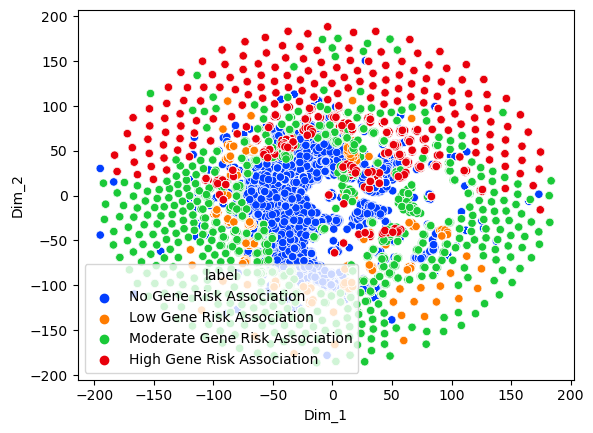

In [84]:
import seaborn as sns
sns.scatterplot(data=tsne_df, x='Dim_1', y='Dim_2',
               hue='label',hue_order = ["No Gene Risk Association", "Low Gene Risk Association","Moderate Gene Risk Association","High Gene Risk Association"], palette="bright")

plt.show()

In [27]:
#tsne_df=tsne_df[tsne_df['label']!=0]
#import seaborn as sns
#sns.scatterplot(data=tsne_df, x='Dim_1', y='Dim_2',
#               hue='label', palette="bright")
#plt.show()

In [28]:
len(idx_train)

16000

In [29]:
len(idx_val)

3200

In [30]:
len(idx_train[(labels==3)[idx_train]])

4000

In [31]:
torch.save(output, 'GraphSage_Upsample_output.pt')

In [32]:
c_out=output.cpu().detach()

In [33]:
preds = output.max(1)[1].type_as(labels)
cout=preds.cpu().detach()
clabels=labels.cpu().detach().numpy()
cidx_test=idx_test.cpu().detach().numpy()
cidx_valid=idx_val.cpu().detach().numpy()
test_out=c_out[cidx_test]


In [34]:
test_out=torch.nn.functional.log_softmax(test_out)

C:\Users\Kyle\AppData\Local\Temp\ipykernel_13996\129021223.py:1: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  test_out=torch.nn.functional.log_softmax(test_out)


In [35]:
valid_out=c_out[cidx_valid]
valid_out=torch.nn.functional.log_softmax(valid_out)

C:\Users\Kyle\AppData\Local\Temp\ipykernel_13996\1260713210.py:2: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  valid_out=torch.nn.functional.log_softmax(valid_out)


In [36]:
c_np=[]
for i in range(len(cout[cidx_test])):
    c_np.append([clabels[cidx_test][i],cout[cidx_test][i]])

In [37]:
dummy_labels=pd.get_dummies(clabels[cidx_test]).values
dummy_preds=pd.get_dummies(cout[cidx_test]).values

In [38]:
from sklearn import metrics
fpr=[]
tpr=[]
roc_auc=[]
import matplotlib.pyplot as plt
for i in range(4):
        fpr_, tpr_, _ = metrics.roc_curve(dummy_labels[:, i], test_out[:, i])
        fpr.append(fpr_)
        tpr.append(tpr_)
        roc_auc.append(roc_auc_score(dummy_labels[:, i], test_out[:, i]))

In [39]:
tpr

[array([0.        , 0.08041799, 0.08465849, ..., 1.        , 1.        ,
        1.        ]),
 array([0.        , 0.29767118, 0.3272293 , ..., 1.        , 1.        ,
        1.        ]),
 array([0.        , 0.23892487, 0.26845855, ..., 1.        , 1.        ,
        1.        ]),
 array([0.        , 0.23617257, 0.24972345, ..., 1.        , 1.        ,
        1.        ])]

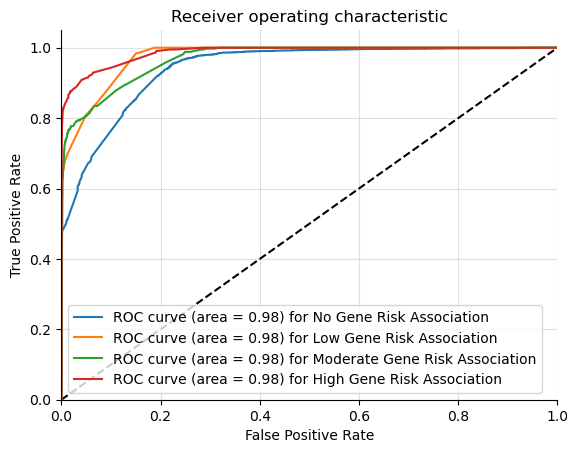

In [72]:
fig, ax = plt.subplots()
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver operating characteristic')
ax.plot(fpr[0], tpr[0], label='ROC curve (area = %0.2f) for %s' % (roc_auc[i], "No Gene Risk Association"))
ax.plot(fpr[3], tpr[3], label='ROC curve (area = %0.2f) for %s' % (roc_auc[i], "Low Gene Risk Association"))
ax.plot(fpr[2], tpr[2], label='ROC curve (area = %0.2f) for %s' % (roc_auc[i], "Moderate Gene Risk Association"))
ax.plot(fpr[1], tpr[1], label='ROC curve (area = %0.2f) for %s' % (roc_auc[i], "High Gene Risk Association"))
ax.legend(loc="best")
ax.grid(alpha=.4)
sns.despine()
plt.show()

In [41]:
#from sklearn import metrics
#fpr, tpr, threshold = metrics.roc_curve(cdf['labels'], cdf['predictions'])
#import matplotlib.pyplot as plt
#plt.title('Receiver Operating Characteristic')
#plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
#plt.legend(loc = 'lower right')
#plt.plot([0, 1], [0, 1],'r--')
#plt.xlim([0, 1])
#plt.ylim([0, 1])
#plt.ylabel('True Positive Rate')
#plt.xlabel('False Positive Rate')
#plt.show()

In [42]:
def specificity(true_negative,false_positive):
    return str(round(true_negative/(true_negative+false_positive),2))
def sensitivity(true_positive,false_negative):
    return str(round(true_positive/(true_positive+false_negative),2))

Text(0.5, 427.9555555555555, 'Predicted label')

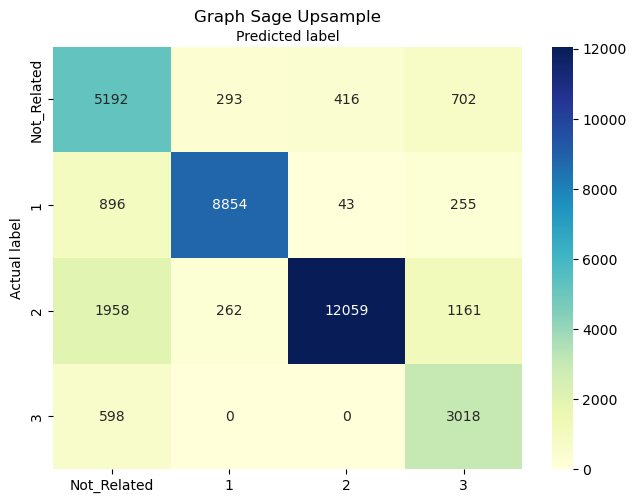

In [43]:
import seaborn as sns
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt 
cnf_matrix_n = metrics.confusion_matrix(clabels[cidx_test], cout[cidx_test])
#class_names=["Not_Related", "Related"]
class_names=["Not_Related", "1","2","3"] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
sns.heatmap(cnf_matrix_n, annot=True, cmap="YlGnBu" ,fmt='d', xticklabels=class_names, yticklabels=class_names)
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Graph Sage Upsample')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [44]:
cnf_matrix_n[0][0]

5192

In [45]:
import sklearn

In [46]:
print(sklearn.metrics.classification_report(clabels[cidx_test], cout[cidx_test], target_names=class_names))

              precision    recall  f1-score   support

 Not_Related       0.60      0.79      0.68      6603
           1       0.94      0.88      0.91     10048
           2       0.96      0.78      0.86     15440
           3       0.59      0.83      0.69      3616

    accuracy                           0.82     35707
   macro avg       0.77      0.82      0.79     35707
weighted avg       0.85      0.82      0.82     35707



In [47]:
cnf_matrix_n

array([[ 5192,   293,   416,   702],
       [  896,  8854,    43,   255],
       [ 1958,   262, 12059,  1161],
       [  598,     0,     0,  3018]], dtype=int64)

In [48]:
#True Positive
True_Positive_0=cnf_matrix_n[0][0]
True_Positive_1=cnf_matrix_n[1][1]
True_Positive_2=cnf_matrix_n[2][2]
True_Positive_3=cnf_matrix_n[3][3]
#True Negative
True_Negatives_0=cnf_matrix_n[1][1]+cnf_matrix_n[1][2]+cnf_matrix_n[1][3]+cnf_matrix_n[2][1]+cnf_matrix_n[2][2]+cnf_matrix_n[2][3]+cnf_matrix_n[3][1]+cnf_matrix_n[3][2]+cnf_matrix_n[3][3]
True_Negatives_1=cnf_matrix_n[0][0]+cnf_matrix_n[0][2]+cnf_matrix_n[0][3]+cnf_matrix_n[2][0]+cnf_matrix_n[2][2]+cnf_matrix_n[2][3]+cnf_matrix_n[3][0]+cnf_matrix_n[3][2]+cnf_matrix_n[3][3]
True_Negatives_2=cnf_matrix_n[0][0]+cnf_matrix_n[0][1]+cnf_matrix_n[0][3]+cnf_matrix_n[2][0]+cnf_matrix_n[2][1]+cnf_matrix_n[2][3]+cnf_matrix_n[3][0]+cnf_matrix_n[3][1]+cnf_matrix_n[3][3]
True_Negatives_3=cnf_matrix_n[0][0]+cnf_matrix_n[0][1]+cnf_matrix_n[0][2]+cnf_matrix_n[1][0]+cnf_matrix_n[1][1]+cnf_matrix_n[1][2]+cnf_matrix_n[2][0]+cnf_matrix_n[2][1]+cnf_matrix_n[2][2]
#False Positive
False_Positive_0=cnf_matrix_n[1][0]+cnf_matrix_n[2][0]+cnf_matrix_n[3][0]
False_Positive_1=cnf_matrix_n[0][1]+cnf_matrix_n[2][1]+cnf_matrix_n[3][1]
False_Positive_2=cnf_matrix_n[0][2]+cnf_matrix_n[1][2]+cnf_matrix_n[3][2]
False_Positive_3=cnf_matrix_n[0][3]+cnf_matrix_n[1][3]+cnf_matrix_n[2][3]
#False Negative
False_Negative_0=cnf_matrix_n[0][1]+cnf_matrix_n[0][2]+cnf_matrix_n[0][3]
False_Negative_1=cnf_matrix_n[1][0]+cnf_matrix_n[1][2]+cnf_matrix_n[1][3]
False_Negative_2=cnf_matrix_n[2][0]+cnf_matrix_n[2][1]+cnf_matrix_n[2][3]
False_Negative_3=cnf_matrix_n[3][0]+cnf_matrix_n[3][1]+cnf_matrix_n[3][2]

In [49]:
print(class_names[0])
print("Specificity: "+ specificity(True_Negatives_0,False_Positive_0))
print("Sensitivity: "+sensitivity(True_Positive_0,False_Negative_0))

print(class_names[1])
print("Specificity: "+specificity(True_Negatives_1,False_Positive_1))
print("Sensitivity: "+sensitivity(True_Positive_1,False_Negative_1))

print(class_names[2])
print("Specificity: "+specificity(True_Negatives_2,False_Positive_2))
print("Sensitivity: "+sensitivity(True_Positive_2,False_Negative_2))

print(class_names[3])
print("Specificity: "+specificity(True_Negatives_3,False_Positive_3))
print("Sensitivity: "+sensitivity(True_Positive_3,False_Negative_3))


Not_Related
Specificity: 0.88
Sensitivity: 0.79
1
Specificity: 0.98
Sensitivity: 0.88
2
Specificity: 0.97
Sensitivity: 0.78
3
Specificity: 0.93
Sensitivity: 0.83


In [50]:
print("test_specificity_0/test_sensitivity_0: " + specificity(True_Negatives_0,False_Positive_0) +"/" +sensitivity(True_Positive_0,False_Negative_0)+
     "   test_specificity_1/test_sensitivity_1: " + specificity(True_Negatives_1,False_Positive_1) +"/" +sensitivity(True_Positive_1,False_Negative_1)+
    "   test_specificity_2/test_sensitivity_2: " + specificity(True_Negatives_2,False_Positive_2) +"/" +sensitivity(True_Positive_2,False_Negative_2)+
     "   test_specificity_3/test_sensitivity_3: " + specificity(True_Negatives_3,False_Positive_3) +"/" +sensitivity(True_Positive_1,False_Negative_3))

test_specificity_0/test_sensitivity_0: 0.88/0.79   test_specificity_1/test_sensitivity_1: 0.98/0.88   test_specificity_2/test_sensitivity_2: 0.97/0.78   test_specificity_3/test_sensitivity_3: 0.93/0.94


Text(0.5, 427.9555555555555, 'Predicted label')

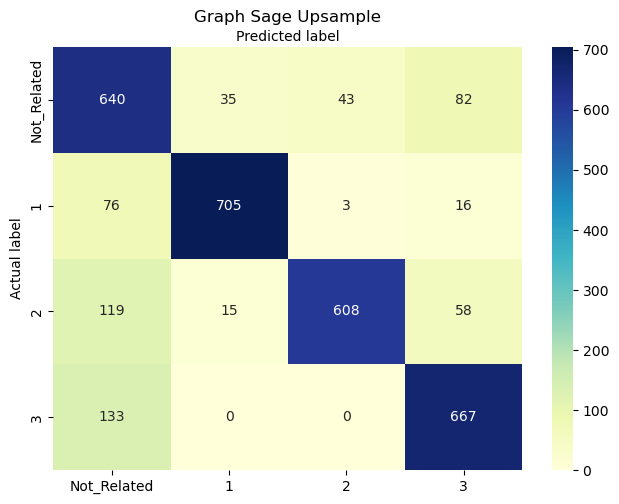

In [51]:
import seaborn as sns
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt 
cnf_matrix_n = metrics.confusion_matrix(clabels[cidx_valid], cout[cidx_valid])
#class_names=["Not_Related", "Related"]
class_names=["Not_Related", "1","2","3"] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
sns.heatmap(cnf_matrix_n, annot=True, cmap="YlGnBu" ,fmt='d', xticklabels=class_names, yticklabels=class_names)
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Graph Sage Upsample')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [52]:
#True Positive
True_Positive_0=cnf_matrix_n[0][0]
True_Positive_1=cnf_matrix_n[1][1]
True_Positive_2=cnf_matrix_n[2][2]
True_Positive_3=cnf_matrix_n[3][3]
#True Negative
True_Negatives_0=cnf_matrix_n[1][1]+cnf_matrix_n[1][2]+cnf_matrix_n[1][3]+cnf_matrix_n[2][1]+cnf_matrix_n[2][2]+cnf_matrix_n[2][3]+cnf_matrix_n[3][1]+cnf_matrix_n[3][2]+cnf_matrix_n[3][3]
True_Negatives_1=cnf_matrix_n[0][0]+cnf_matrix_n[0][2]+cnf_matrix_n[0][3]+cnf_matrix_n[2][0]+cnf_matrix_n[2][2]+cnf_matrix_n[2][3]+cnf_matrix_n[3][0]+cnf_matrix_n[3][2]+cnf_matrix_n[3][3]
True_Negatives_2=cnf_matrix_n[0][0]+cnf_matrix_n[0][1]+cnf_matrix_n[0][3]+cnf_matrix_n[2][0]+cnf_matrix_n[2][1]+cnf_matrix_n[2][3]+cnf_matrix_n[3][0]+cnf_matrix_n[3][1]+cnf_matrix_n[3][3]
True_Negatives_3=cnf_matrix_n[0][0]+cnf_matrix_n[0][1]+cnf_matrix_n[0][2]+cnf_matrix_n[1][0]+cnf_matrix_n[1][1]+cnf_matrix_n[1][2]+cnf_matrix_n[2][0]+cnf_matrix_n[2][1]+cnf_matrix_n[2][2]
#False Positive
False_Positive_0=cnf_matrix_n[1][0]+cnf_matrix_n[2][0]+cnf_matrix_n[3][0]
False_Positive_1=cnf_matrix_n[0][1]+cnf_matrix_n[2][1]+cnf_matrix_n[3][1]
False_Positive_2=cnf_matrix_n[0][2]+cnf_matrix_n[1][2]+cnf_matrix_n[3][2]
False_Positive_3=cnf_matrix_n[0][3]+cnf_matrix_n[1][3]+cnf_matrix_n[2][3]
#False Negative
False_Negative_0=cnf_matrix_n[0][1]+cnf_matrix_n[0][2]+cnf_matrix_n[0][3]
False_Negative_1=cnf_matrix_n[1][0]+cnf_matrix_n[1][2]+cnf_matrix_n[1][3]
False_Negative_2=cnf_matrix_n[2][0]+cnf_matrix_n[2][1]+cnf_matrix_n[2][3]
False_Negative_3=cnf_matrix_n[3][0]+cnf_matrix_n[3][1]+cnf_matrix_n[3][2]

In [53]:
print(class_names[0])
print("Specificity: "+ specificity(True_Negatives_0,False_Positive_0))
print("Sensitivity: "+sensitivity(True_Positive_0,False_Negative_0))

print(class_names[1])
print("Specificity: "+specificity(True_Negatives_1,False_Positive_1))
print("Sensitivity: "+sensitivity(True_Positive_1,False_Negative_1))

print(class_names[2])
print("Specificity: "+specificity(True_Negatives_2,False_Positive_2))
print("Sensitivity: "+sensitivity(True_Positive_2,False_Negative_2))

print(class_names[3])
print("Specificity: "+specificity(True_Negatives_3,False_Positive_3))
print("Sensitivity: "+sensitivity(True_Positive_3,False_Negative_3))

Not_Related
Specificity: 0.86
Sensitivity: 0.8
1
Specificity: 0.98
Sensitivity: 0.88
2
Specificity: 0.97
Sensitivity: 0.76
3
Specificity: 0.94
Sensitivity: 0.83


In [54]:
print("valid_specificity_0/valid_sensitivity_0: " + specificity(True_Negatives_0,False_Positive_0) +"/" +sensitivity(True_Positive_0,False_Negative_0)+
     "   valid_specificity_1/valid_sensitivity_1: " + specificity(True_Negatives_1,False_Positive_1) +"/" +sensitivity(True_Positive_1,False_Negative_1)+
    "   valid_specificity_2/valid_sensitivity_2: " + specificity(True_Negatives_2,False_Positive_2) +"/" +sensitivity(True_Positive_2,False_Negative_2)+
     "   valid_specificity_3/valid_sensitivity_3: " + specificity(True_Negatives_3,False_Positive_3) +"/" +sensitivity(True_Positive_1,False_Negative_3))

valid_specificity_0/valid_sensitivity_0: 0.86/0.8   valid_specificity_1/valid_sensitivity_1: 0.98/0.88   valid_specificity_2/valid_sensitivity_2: 0.97/0.76   valid_specificity_3/valid_sensitivity_3: 0.94/0.84


In [55]:
test_labels=clabels[cidx_test]
test_outputs=cout[cidx_test]
valid_labels=clabels[cidx_valid]
valid_outputs=cout[cidx_valid]

In [56]:
test_outputs

tensor([0, 0, 3,  ..., 3, 0, 3])

In [57]:
test_labels_enc=np.eye(4)[test_labels]
test_output_enc=np.eye(4)[test_outputs]
valid_labels_enc=np.eye(4)[valid_labels]
valid_output_enc=np.eye(4)[valid_outputs]

In [58]:
from sklearn.metrics import f1_score,precision_score,average_precision_score

In [59]:
f1_score(test_labels_enc, test_output_enc,average='weighted')

0.8249068747575347

In [60]:
f1_score(test_labels_enc, test_output_enc,average=None)

array([0.68105201, 0.91010947, 0.86265112, 0.68967093])

In [61]:
f1_score(valid_labels_enc, valid_output_enc,average='weighted')

0.8222456546206166

In [62]:
f1_score(valid_labels_enc, valid_output_enc,average=None)

array([0.7239819 , 0.90675241, 0.83631362, 0.82193469])

In [63]:
average_precision_score(test_labels_enc, test_out,average='weighted')

0.9242016320349878

In [64]:
average_precision_score(valid_labels_enc, valid_out,average='weighted')

0.9123311469390342

In [65]:
from sklearn.metrics import (precision_recall_curve, PrecisionRecallDisplay)
from sklearn import metrics
precisions=[]
recalls=[]
import matplotlib.pyplot as plt
for i in range(4):
        precision, recall, _ = precision_recall_curve(dummy_labels[:, i], test_out[:, i])
        precisions.append(precision)
        recalls.append(recall)
        

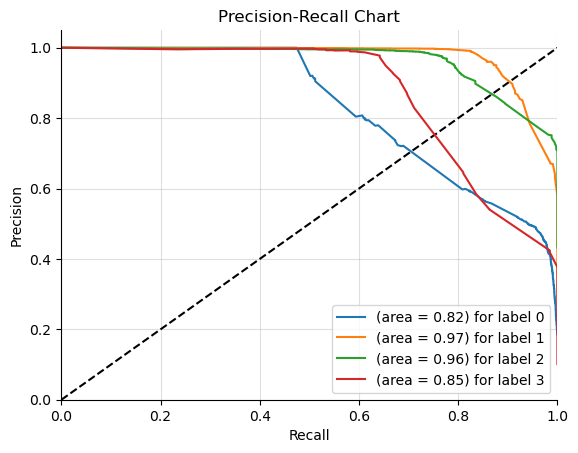

In [66]:
fig, ax = plt.subplots()
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Precision-Recall Chart')
ap=average_precision_score(test_labels_enc, test_out,average=None)
for i in range(4):
    ax.plot(recalls[i], precisions[i], label='(area = %0.2f) for label %i' % (ap[i], i))
ax.legend(loc="best")
ax.grid(alpha=.4)
sns.despine()
plt.show()

In [67]:
test_output

NameError: name 'test_output' is not defined

In [ ]:
conf, classes = torch.max(output, 1)

In [ ]:
classes

In [ ]:
conf

In [ ]:
output[cidx_test]

In [ ]:
output[valid_output]

In [ ]:
len(g.nodes())

In [ ]:
nx.adjacency_matrix(g,weight=None)

In [ ]:
adj

In [ ]:
conf, classes = torch.max(torch.nn.functional.softmax(output[:len(g.nodes())],dim=1), 1)

In [ ]:
g_nodes=np.array(g.nodes())

In [ ]:
c_conf=conf.cpu().detach().numpy()
c_classes=classes.cpu().detach().numpy()

In [ ]:
confidence=[]
for i in range(len(g_nodes)):
    confidence.append([g_nodes[i],c_classes[i],clabels[i],c_conf[i]])

In [ ]:
df_gene_confidence=pd.DataFrame(confidence,columns=['Gene','Predicted Class','Actual Class','Confidence'])

In [ ]:
df_gene_confidence_1=df_gene_confidence[df_gene_confidence['Predicted Class']==1].sort_values(by=['Confidence'], ascending=False)

In [ ]:
df_gene_confidence_0=df_gene_confidence[df_gene_confidence['Predicted Class']==0].sort_values(by=['Confidence'], ascending=False)

In [ ]:
df_gene_confidence_1[df_gene_confidence_1['Confidence']<1.0]['Confidence']

In [ ]:
#df_gene_confidence.to_csv("Confidence_rates_multi-class.csv")